In [1]:
import pandas as pd
import numpy as np
import scipy
import os
import time
import json
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import disperse

import sklearn
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
#Генерация признаков плотности галактик вокруг точки

def gen_feas(galaxies, clusters):
    false_mask = (clusters['type'] == 0).values
    
    cl_coords = clusters[['CX', 'CY', 'CZ']].values
    g_coords = galaxies[['CX', 'CY', 'CZ']].values
    
    if false_mask.sum() > 0:
        kd_tree = KDTree(cl_coords[false_mask])
        dists, ids = kd_tree.query(g_coords, k=1, return_distance=True)
        drop_mask = (dists < 0.001).reshape(-1)
        print(drop_mask.sum(), drop_mask.shape)
    else:
        drop_mask = np.array([False] * g_coords.shape[0])
    
    kd_tree = KDTree(g_coords[~drop_mask, :])
    
    cme_rads = [0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, 7.5, 10.0, 12.0]
    cmd = []
    mi = []
    enc = []
    
    for r in tqdm(cme_rads):
        nn_idx, nn_dists = kd_tree.query_radius(cl_coords, r=r, return_distance=True)
        t_cmd = []
        t_mi = []
        t_enc = []
        for i, idx in enumerate(nn_idx):
            if len(idx) == 0:
                continue
            if nn_dists[i].min() < 0.01:
                nn_idx[i] = np.delete(nn_idx[i], nn_dists[i].argmin())
                nn_dists[i] = np.delete(nn_dists[i], nn_dists[i].argmin())
        for i, idx in enumerate(nn_idx):
            if len(idx) == 0:
                t_cmd.append(-1)
                t_mi.append(0)
                t_enc.append(0)
                continue
            t_enc.append(len(idx))
            nn_coords = g_coords[idx]
            mass_center = nn_coords.mean(0)
            t_cmd.append((((cl_coords[i] - mass_center)**2).sum())**0.5)
            t_mi.append((nn_dists[i]**2).sum())
        cmd.append(t_cmd)
        mi.append(t_mi)
        enc.append(t_enc)
    
    cmd = np.array(cmd).T
    mi = np.array(mi).T
    enc = np.array(enc).T
    
    _pca = PCA(n_components=3)
    pca_rads = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    pca = []
    
    for r in tqdm(pca_rads):
        nn_idx, nn_dists = kd_tree.query_radius(cl_coords, r=r, return_distance=True)
        t_pca = []
        for i, idx in enumerate(nn_idx):
            if len(idx) == 0:
                continue
            if nn_dists[i].min() < 0.01:
                nn_idx[i] = np.delete(nn_idx[i], nn_dists[i].argmin())
                nn_dists[i] = np.delete(nn_dists[i], nn_dists[i].argmin())
        for i, idx in enumerate(nn_idx):
            if len(idx) < 3:
                t_pca.append(-1)
                continue
            nn_coords = g_coords[idx]
            _pca.fit(nn_coords)
            var_ratio = _pca.explained_variance_ratio_
            t_pca.append(max(var_ratio) - min(var_ratio))
        pca.append(t_pca)
    
    pca = np.array(pca).T
    
    knn_3d_num = [1, 2, 3, 5, 8, 10, 15, 20, 25, 30, 35, 40]
    knn_3d = []
    
    for n in tqdm(knn_3d_num):
        nn_dists, nn_idx = kd_tree.query(cl_coords, k=n+1)
        t_knn = []
        for d in nn_dists:
            if d[0] >= 0.01:
                t_knn.append(d[n-1])
            else:
                t_knn.append(d[n])
        knn_3d.append(t_knn)
    
    knn_3d = np.array(knn_3d).T
    
    kd_tree = KDTree(galaxies[['RA', 'DEC']].values[~drop_mask, :])
    knn_2d_num = [1, 2, 3, 4, 5, 6, 7]
    knn_2d = []
    g_Z = galaxies['Z'].values
    cl_Z = clusters['Z'].values
    
    for n in tqdm(knn_2d_num):
        dists, ids = kd_tree.query(
            clusters[['RA', 'DEC']].values, k=n+1, return_distance=True
        )
        t_knn = []
        t_z_diff = []
        for i, d in enumerate(dists):
            if d[0] >= 0.001:
                t_z_diff.append(np.abs(g_Z[ids[i][n-1]] - cl_Z[i]))
            else:
                t_z_diff.append(np.abs(g_Z[ids[i][n]] - cl_Z[i]))
        knn_2d.append(t_z_diff)
        
    knn_2d = np.array(knn_2d).T
        
    
    feas = np.concatenate([cmd, mi, enc, knn_3d, knn_2d, pca], axis=1)
    
    return feas

In [3]:
# Космологические постоянные

cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [4]:
np.random.seed(0)

In [5]:
gal_RA_int = (140, 260)
gal_DEC_int = (-10, 30)
gal_Z_int = (0, 1.0)

In [6]:
# Загрузка каталога галактик

galaxies = pd.read_csv('ACT_01_galaxies.csv')
galaxies

RA        DEC             Z           CX           CY  \
0       246.57670  24.555640  4.440446e-07    -0.000710    -0.001639   
1       164.13474  26.790246  2.660330e-06    -0.010105     0.002872   
2       148.27174  13.852512  2.941728e-06    -0.010746     0.006644   
3       162.39490   0.634081  2.985324e-06    -0.012587     0.003994   
4       192.18382  29.157491  4.336780e-06    -0.016376    -0.003536   
...           ...        ...           ...          ...          ...   
931855  150.82080  27.459191  9.999520e-01 -2632.647935  1470.083208   
931856  145.90217  17.815348  9.999526e-01 -2678.991489  1813.665628   
931857  148.54341  23.989890  9.999846e-01 -2648.386298  1620.174441   
931858  172.28138  22.292154  9.999892e-01 -3115.753059   422.297455   
931859  240.54752   2.411359  9.999976e-01 -1669.439854 -2956.443479   

                 CZ      ID  
0          0.000816       0  
1          0.005304       1  
2          0.003116       2  
3          0.000146       3  
4          0.009347       4  
...             ...     ...  
931855  1566.932516  931855  
931856  1039.658140  931856  
931857  1381.627428  931857  
931858  1289.044302  931858  
931859   142.976591  931859  

[931860 rows x 7 columns]

In [7]:
Z_MAX = 0.6
Z_MIN = 0.02

cl_RA_int = (160, 240)
cl_DEC_int = (0, 20)
cl_Z_int = (Z_MIN, Z_MAX)

In [8]:
# Загркзка каталога скоплений галактик

clusters = pd.read_csv('ACT_01_clusters.csv')
true_size = (clusters['type'] == 1).sum()
true_mask = (clusters['type'] == 1).values
false_mask = ~true_mask
clusters

RA        DEC         Z          M  R  type           CX  \
0     230.761495   8.587807  0.035200   1.676978  0     1   -96.597031   
1     230.452957   7.709549  0.044200   2.457475  0     1  -122.101803   
2     227.733561   5.744353  0.076600  11.002140  0     1  -222.703294   
3     208.253128   5.139146  0.078800   1.222567  0     1  -300.190348   
4     173.207731  14.465334  0.083200   2.935207  0     1  -346.994931   
...          ...        ...       ...        ... ..   ...          ...   
4514  210.390460  17.938115  0.604371   0.000000  0     0 -1876.267534   
4515  249.169420  18.722937  0.604616   0.000000  0     0  -770.249252   
4516  186.142140  11.929887  0.604905   0.000000  0     0 -2225.692220   
4517  201.042360  12.265017  0.605352   0.000000  0     0 -2087.933348   
4518  176.813910  -2.564162  0.605738   0.000000  0     0 -2284.756260   

               CY          CZ    ID  ...   dist_12.2   dist_12.4   dist_12.6  \
0     -118.277283   23.062053     0  ...    6.432487  101.423067  101.423067   
1     -147.873793   25.960786     1  ...    8.378063  135.818132  135.818132   
2     -245.035914   33.308899     2  ...    1.570683  267.106804  267.106804   
3     -161.319215   30.649445     3  ...    1.138946  223.929466  223.929466   
4       41.329156   90.147741     4  ...   19.328642  127.612739  127.612739   
...           ...         ...   ...  ...         ...         ...         ...   
4514 -1100.379724  704.147961  4514  ...  295.190599  295.190599  295.190599   
4515 -2024.439965  734.123790  4515  ...  646.876537  646.876537  646.876537   
4516  -239.513664  472.954573  4516  ...  310.980908  310.980908  310.980908   
4517  -803.254137  486.339264  4517  ...  399.752201  399.752201  399.752201   
4518   127.181298 -102.476573  4518  ...  401.393942  401.393942  401.393942   

       dist_12.8   dist_13.0   dist_13.2   dist_13.4   dist_13.6   dist_13.8  \
0     101.423067  101.423067  101.423067  101.423067  101.423067  101.423067   
1     135.818132  135.818132  135.818132  135.818132  135.818132  135.818132   
2     267.106804  267.106804  267.106804  267.106804  267.106804  267.106804   
3     223.929466  223.929466  223.929466  223.929466  223.929466  223.929466   
4     127.612739  127.612739  127.612739  127.612739  127.612739  127.612739   
...          ...         ...         ...         ...         ...         ...   
4514  295.190599  295.190599  295.190599  295.190599  295.190599  295.190599   
4515  646.876537  646.876537  646.876537  646.876537  646.876537  646.876537   
4516  310.980908  310.980908  310.980908  310.980908  310.980908  310.980908   
4517  399.752201  399.752201  399.752201  399.752201  399.752201  399.752201   
4518  401.393942  401.393942  401.393942  401.393942  401.393942  401.393942   

       dist_14.0  
0     101.423067  
1     135.818132  
2     267.106804  
3     223.929466  
4     127.612739  
...          ...  
4514  295.190599  
4515  646.876537  
4516  310.980908  
4517  399.752201  
4518  401.393942  

[4519 rows x 80 columns]

In [9]:
false_mask.sum()

4119

In [10]:
# Инициализация класса Disperse

util_DPS = disperse.Disperse3D(
    galaxies, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=None
)

In [11]:
sigmas = [round(i, 1) for i in np.arange(0.2, 14.2, 0.2)]

In [12]:
# Инициализация набора признаков плотности галактик

# dists_names = []
# for sigma in sigmas:
#     dists_names.append(f'dist_{sigma}')

# #Z

# cme_rads = [0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, 7.5, 10.0, 12.0]
# knn_3d_num = [1, 2, 3, 5, 8, 10, 15, 20, 25, 30, 35, 40]
# knn_2d_num = [1, 2, 3, 4, 5, 6, 7]
# pca_rads = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

# cmd_names = []
# for r in cme_rads:
#     cmd_names.append(f'cmd_{r}')
# mi_names = []
# for r in cme_rads:
#     mi_names.append(f'mi_{r}')
# enc_names = []
# for r in cme_rads:
#     enc_names.append(f'enc_{r}')

# knn_3d_names = []
# for n in knn_3d_num:
#     knn_3d_names.append(f'knn_3d_{n}')
    
# knn_2d_names = []
# for n in knn_2d_num:
#     knn_2d_names.append(f'knn_2d_{n}')
    
# pca_names = []
# for r in pca_rads:
#     pca_names.append(f'pca_{r}')
    
# feas_names = dists_names + ['Z'] + \
#              cmd_names + mi_names + \
#              enc_names + knn_3d_names + knn_2d_names + pca_names
# fea2ids = {k: i for i, k in zip(range(len(feas_names)), feas_names)}

# feas_names = np.array(feas_names)
# feas_names = {i: k for i, k in zip(range(len(feas_names)), feas_names)}
# feas_names

In [13]:
# with open('ACT_02_res.json', 'r') as f:
#     res = json.load(f)
    
# last_fea = sorted(res, key=lambda x: (-x[4], -x[3], -x[1]))[0][5]
# for f in res:
#     if f[5] == last_fea:
#         break
#     else:
#         feas_names.remove(f[5])
        
# feas_ids = []
# for f in feas_names:
#     feas_ids.append(fea2ids[f])
# feas_ids = sorted(feas_ids)
# feas_ids = np.array(feas_ids)

In [14]:
# Расчет, сохранение и загрузка призаков, связанных с расположением скоплений относительно филаментов, 
# построенных Disperse

f_name = 'ACT_01_dists_train.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists = np.load(f)
else:
    dists = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(clusters['R'], clusters)
        dists.append(np.array(cl_dists)[None,:])
    dists = np.concatenate(dists, axis=0)
    dists = dists.T
    with open(f_name, 'wb') as f:
        np.save(f, dists)
    
print(dists.shape)

(4519, 70)


In [15]:
# Расчет признаков плотности галактик

# dens_feas = gen_feas(galaxies, clusters)

In [16]:
# Загрузка признаков

# feas = np.concatenate((
#     dists, 
#     clusters['Z'].values.reshape(-1, 1), 
#     dens_feas
# ), axis=1)

# np.save('ACT_02_feas.npy', feas)
feas = np.load('ACT_02_feas.npy')#[:, feas_ids]
y = clusters['type'].values.astype(int)

feas.shape

(4519, 129)

In [17]:
# Настройка двойной кросс-валидации

FOLDS_NUM = 2

folds = []

for i in range(FOLDS_NUM):
    test_index = np.array(list(range(i, clusters.shape[0], FOLDS_NUM)))
    train_index = set(range(clusters.shape[0])) - set(test_index)
    train_index = np.array(sorted(train_index))
    weights = np.ones(train_index.shape)
#     weights[train_index < train_size] = 10
    folds.append((train_index, test_index, weights))

train_index = folds[0][0]
test_index = folds[0][1]

train_mask = np.array([False] * clusters.shape[0])
train_mask[train_index] = True
test_mask = ~train_mask

In [18]:
# Обучение модели первого уровня (случайный лес) с помощью двойной кросс-валидации
# Расчет метрики ROC-AUC

rfs = []
rf_scores = np.zeros(clusters.shape[0])
rf_rocaucs = []
for train_index, test_index, weights in folds:
    rf = RandomForestClassifier(
        max_depth=13, 
        random_state=0,
        n_estimators=600,
        max_features='auto'
    ).fit(feas[train_index], y[train_index], weights)
    rfs.append(rf)
    preds = rf.predict_proba(feas[test_index])[:,1].reshape(-1)
    rf_scores[test_index] = preds
    rf_rocaucs.append(roc_auc_score(y[test_index], preds))
    
# rf_scores /= len(rfs)
    
print(rf_rocaucs)
print(roc_auc_score(y, rf_scores))

[0.9811929611650485, 0.9769511898980088]
0.9788337581937363


In [19]:
# Обучение модели первого уровня (градиентный бустинг) с помощью двойной кросс-валидации
# Расчет метрики ROC-AUC

boostings = []
boosting_scores = np.zeros(clusters.shape[0])
boosting_rocaucs = []
for train_index, test_index, weights in folds:
    boosting = lgbm.LGBMClassifier(
        boosting_type='gbdt', objective='binary',
        learning_rate=0.05, n_estimators=200,
        max_depth=2, bagging_fraction=1.0,
        reg_lambda=0.1
    ).fit(feas[train_index], y[train_index], weights)
    boostings.append(boosting)
    preds = boosting.predict_proba(feas[test_index])[:,1].reshape(-1)
    boosting_scores[test_index] = preds
    boosting_rocaucs.append(roc_auc_score(y[test_index], preds))
    
# boosting_scores /= len(boostings)

print(boosting_rocaucs)
print(roc_auc_score(y, boosting_scores))

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[0.98648786407767, 0.986500728508985]
0.9862812575867929


In [20]:
# 0.984239196406895

In [21]:
# fi = boostings[0].feature_importances_
# s = np.argsort(fi)[::-1]
# print(fi)
# font = {'size': 20}
# plt.rc('font', **font)
# fig = plt.figure(figsize=(10, 40))
# plt.grid()
# plt.barh(np.array(feas_names)[s], fi[s])

In [22]:
# Расчет вероятности нахождения скоплений в точках по лучу в направлении скоплений
# Загрузка

z = [round(i, 4) for i in np.arange(Z_MIN, Z_MAX, 0.002)]

# ID, RA, DEC, Z, Z_true, M, R, TYPE = [], [], [], [], [], [], [], []
# for i in tqdm(range(clusters.shape[0])):
#     row = clusters.iloc[i]
#     ID = ID + [int(row['ID'])] * len(z)
#     RA = RA + [row['RA']] * len(z)
#     DEC = DEC + [row['DEC']] * len(z)
#     Z = Z + z.copy()
#     Z_true = Z_true + [row['Z']] * len(z)
#     TYPE = TYPE + [int(row['type'])] * len(z)
# CX, CY, CZ = util_DPS.sph2cart(RA, DEC, Z)
# clusters_ext = pd.DataFrame({
#     'ID': ID, 'RA': RA, 'DEC': DEC, 'Z': Z,
#     'CX': CX, 'CY': CY, 'CZ': CZ,
#     'Z_true': Z_true, 'type': TYPE
# })

z = np.array(z)

clusters_ext = pd.read_csv('ACT_02_clusters_ext.csv')
clusters_ext

ID          RA       DEC      Z           CX          CY  \
0           0  230.761495  8.587807  0.020   -55.080504  -67.442781   
1           0  230.761495  8.587807  0.022   -60.560280  -74.152438   
2           0  230.761495  8.587807  0.024   -66.034892  -80.855773   
3           0  230.761495  8.587807  0.026   -71.504334  -87.552778   
4           0  230.761495  8.587807  0.028   -76.968601  -94.243446   
...       ...         ...       ...    ...          ...         ...   
1310505  4518  176.813910 -2.564162  0.590 -2234.975140  124.410224   
1310506  4518  176.813910 -2.564162  0.592 -2241.327829  124.763847   
1310507  4518  176.813910 -2.564162  0.594 -2247.672844  125.117044   
1310508  4518  176.813910 -2.564162  0.596 -2254.010195  125.469813   
1310509  4518  176.813910 -2.564162  0.598 -2260.339889  125.822157   

                 CZ    Z_true  type  rf_score  boosting_score  
0         13.150192  0.035200     1  0.005000        0.001607  
1         14.458461  0.035200     1  0.003409        0.032017  
2         15.765497  0.035200     1  0.025081        0.028620  
3         17.071298  0.035200     1  0.072859        0.068672  
4         18.375864  0.035200     1  0.130924        0.210676  
...             ...       ...   ...       ...             ...  
1310505 -100.243775  0.605738     0  0.001667        0.000446  
1310506 -100.528708  0.605738     0  0.001667        0.000395  
1310507 -100.813296  0.605738     0  0.003333        0.000369  
1310508 -101.097541  0.605738     0  0.005000        0.000451  
1310509 -101.381443  0.605738     0  0.018333        0.000388  

[1310510 rows x 11 columns]

In [23]:
f_name = 'ACT_01_dists_ext_train.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists_ext = np.load(f)
else:
    dists_ext = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn([0] * clusters_ext.shape[0], clusters_ext)
        dists_ext.append(np.array(cl_dists)[None,:])
    dists_ext = np.concatenate(dists_ext, axis=0)
    dists_ext = dists_ext.T
    with open(f_name, 'wb') as f:
        np.save(f, dists_ext)

print(dists_ext.shape)

(1310510, 70)


In [24]:
# dens_feas_ext = gen_feas(galaxies, clusters_ext)

In [25]:
# feas_ext = np.concatenate((
# #     dists_ext, 
#     clusters_ext['Z'].values.reshape(-1, 1),
#     dens_feas_ext,
# ), axis=1)

# np.save('ACT_02_feas_ext.npy', feas_ext)
feas_ext = np.load('ACT_02_feas_ext.npy')#[:, feas_ids]
y = clusters['type'].values.astype(int)

feas_ext.shape

(1310510, 129)

In [26]:
# Обучение моделей второго уровня (градиентный бустинг и случайный лес)

In [27]:
rf_scores_ext = np.zeros(clusters_ext.shape[0])
boosting_scores_ext = np.zeros(clusters_ext.shape[0])
for i, (train_index, test_index, weights) in enumerate(folds):
    ids = clusters['ID'].iloc[test_index]
    m = clusters_ext['ID'].isin(ids)
    rf_scores_ext[m] = rfs[i].predict_proba(feas_ext[m])[:, 1].reshape(-1)
    boosting_scores_ext[m] = boostings[i].predict_proba(feas_ext[m])[:, 1].reshape(-1)
    
# rf_scores_ext /= len(rfs)
# boosting_scores_ext /= len(boostings)

In [28]:
clusters_ext['rf_score'] = rf_scores_ext
clusters_ext['boosting_score'] = boosting_scores_ext

In [29]:
rf_scores_ext_lvl2 = np.zeros(clusters.shape[0])
rf_pred_z_ext_lvl2 = np.zeros(clusters.shape[0])
boosting_scores_ext_lvl2 = np.zeros(clusters.shape[0])
boosting_pred_z_ext_lvl2 = np.zeros(clusters.shape[0])
for i in tqdm(range(clusters.shape[0])):
    id_ = clusters['ID'].values[i]
    rf_scores_ext_lvl2[i] = clusters_ext[clusters_ext['ID'] == id_]['rf_score'].max()
    rf_pred_z_ext_lvl2[i] = z[(z >= Z_MIN) & (z <= Z_MAX)][clusters_ext[clusters_ext['ID'] == id_]['rf_score'].argmax()]
    boosting_scores_ext_lvl2[i] = clusters_ext[clusters_ext['ID'] == id_]['boosting_score'].max()
    boosting_pred_z_ext_lvl2[i] = z[(z >= Z_MIN) & (z <= Z_MAX)][clusters_ext[clusters_ext['ID'] == id_]['boosting_score'].argmax()]

100%|██████████| 4519/4519 [00:22<00:00, 202.10it/s]


In [30]:
# ROC-AUC метрики моделей второго уровня

In [31]:
print(roc_auc_score(y, rf_scores_ext_lvl2))
print(roc_auc_score(y, boosting_scores_ext_lvl2))

0.8422107914542365
0.8846057902403496


In [32]:
# 0.87109

In [33]:
# Гистограммы растпределений вероятностей скопления для истинных и ложных скоплений

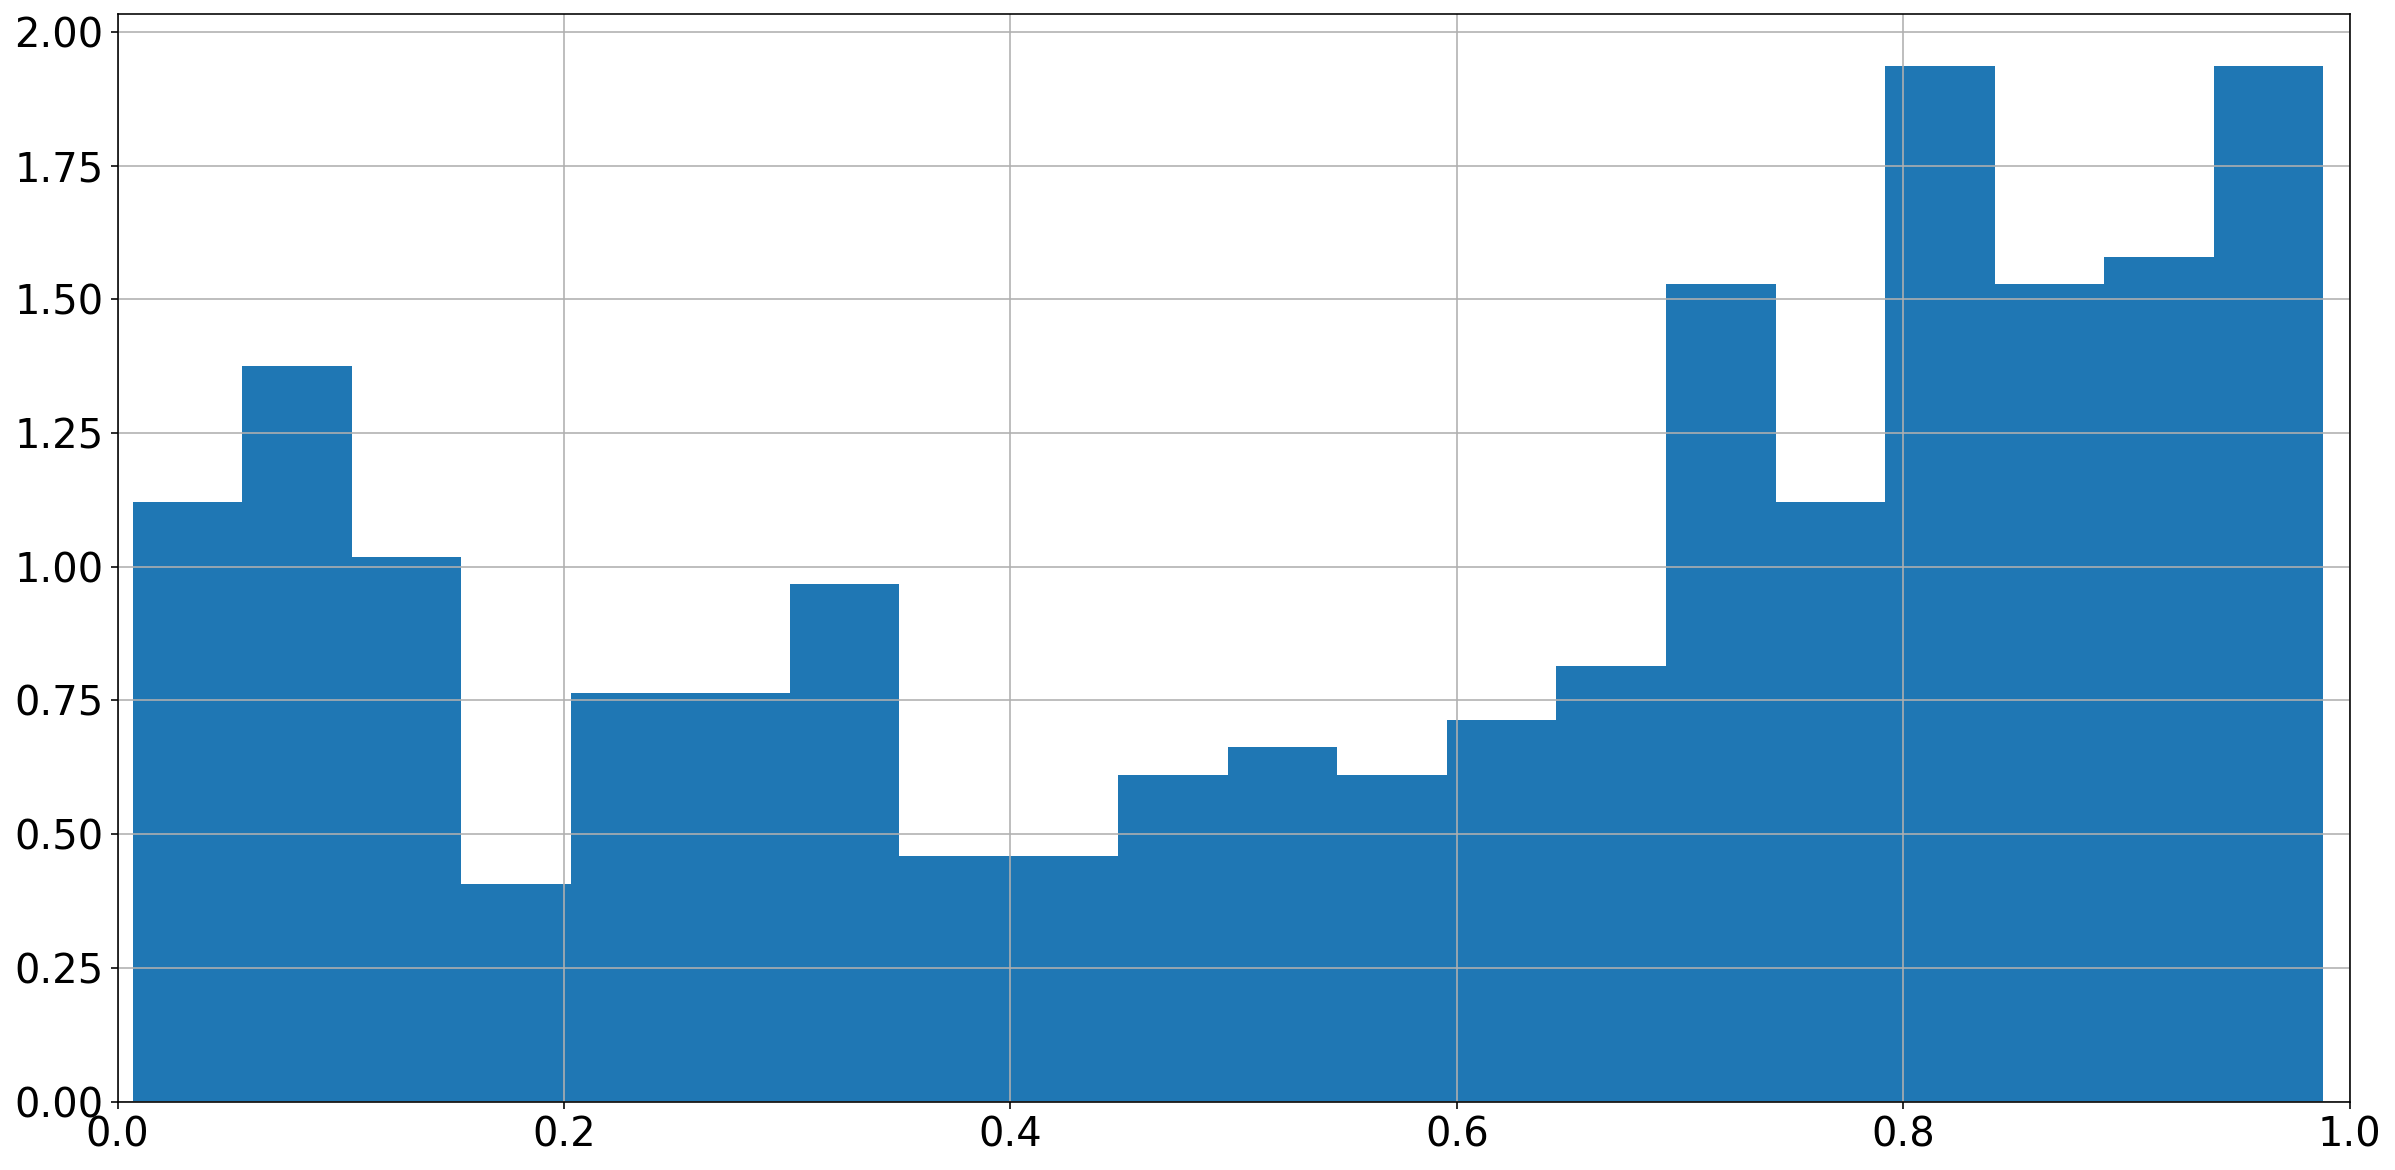

In [34]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 10))
plt.xlim((0, 1))
plt.grid()

plt.hist(boosting_scores_ext_lvl2[true_mask], bins=20, density=True);

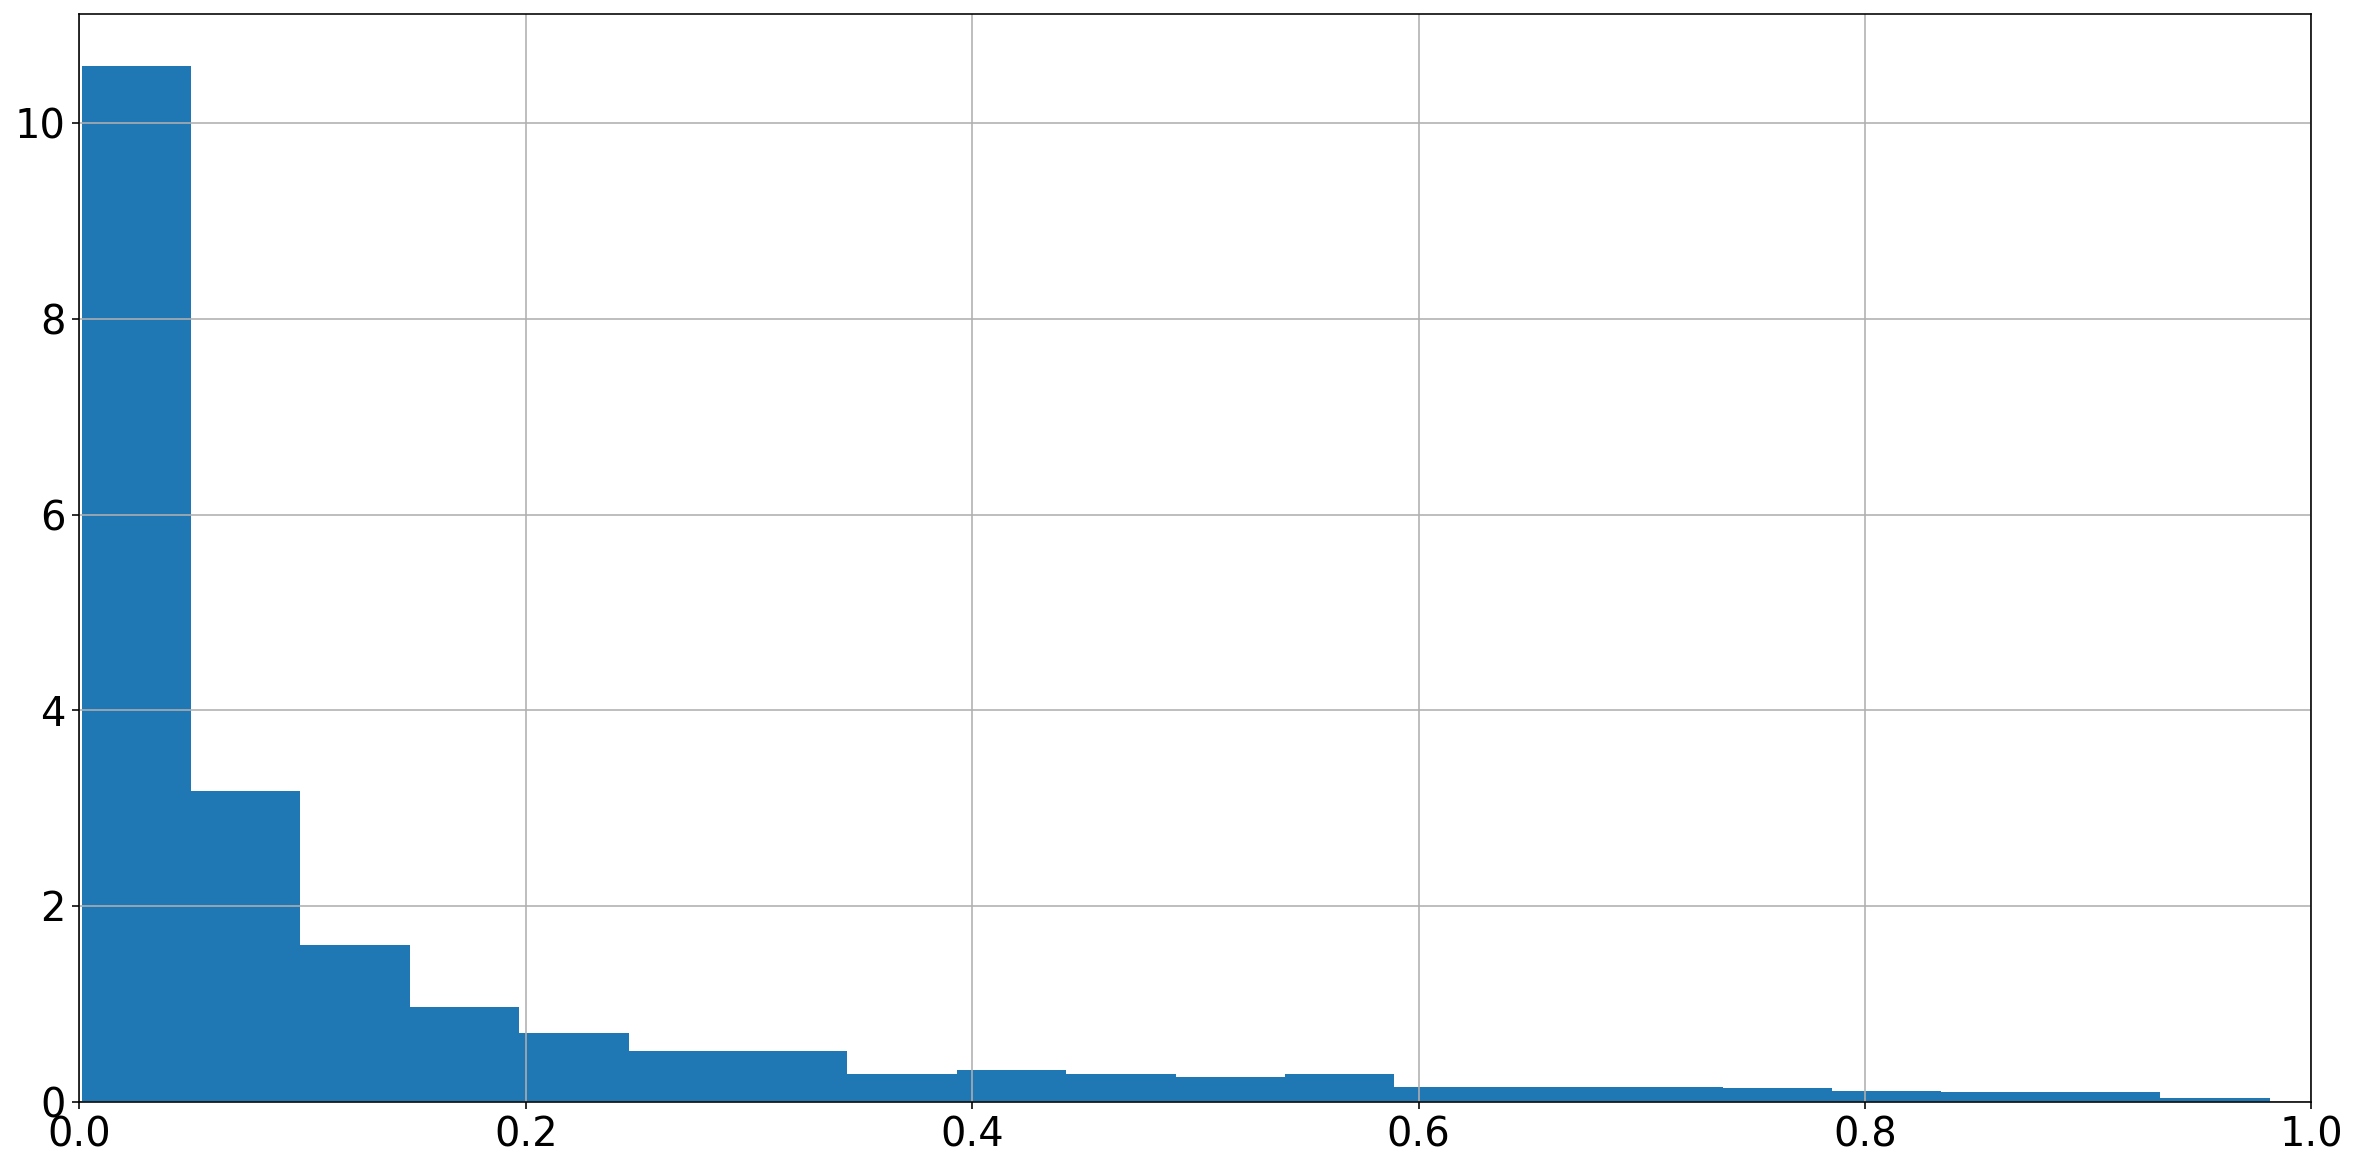

In [35]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 10))
plt.xlim((0, 1))
plt.grid()

plt.hist(boosting_scores_ext_lvl2[false_mask], bins=20, density=True);

In [60]:
CLOSE_THR = 0.15
close_mask = (np.abs((rf_pred_z_ext_lvl2[true_mask] - clusters['Z'][true_mask]) / (1 + clusters['Z'][true_mask])) < CLOSE_THR)

In [61]:
# Доля катастрофических выбросов для модели второго уровня (случайный лес)
1 - close_mask.sum() / clusters['Z'][true_mask].shape[0]

0.06499999999999995

In [62]:
CLOSE_THR = 0.15
close_mask = (np.abs((boosting_pred_z_ext_lvl2[true_mask] - clusters['Z'][true_mask]) / (1 + clusters['Z'][true_mask])) < CLOSE_THR)

In [63]:
# Доля катастрофических выбросов для модели второго уровня (градиентный бустинг)

1 - close_mask.sum() / clusters['Z'][true_mask].shape[0]

0.01749999999999996

In [64]:
# sigma_nmad (случайный лес)
rf_nmad = 1.48 * np.median(np.abs((rf_pred_z_ext_lvl2[true_mask] - clusters['Z'][true_mask]) / (1 + clusters['Z'][true_mask])))
rf_nmad

0.0012261036688324943

In [65]:
# sigma_nmad (градиентный бустинг)
boost_nmad = 1.48 * np.median(np.abs((boosting_pred_z_ext_lvl2[true_mask] - clusters['Z'][true_mask]) / (1 + clusters['Z'][true_mask])))
boost_nmad

0.001137017819915647

In [38]:
# 0.0224

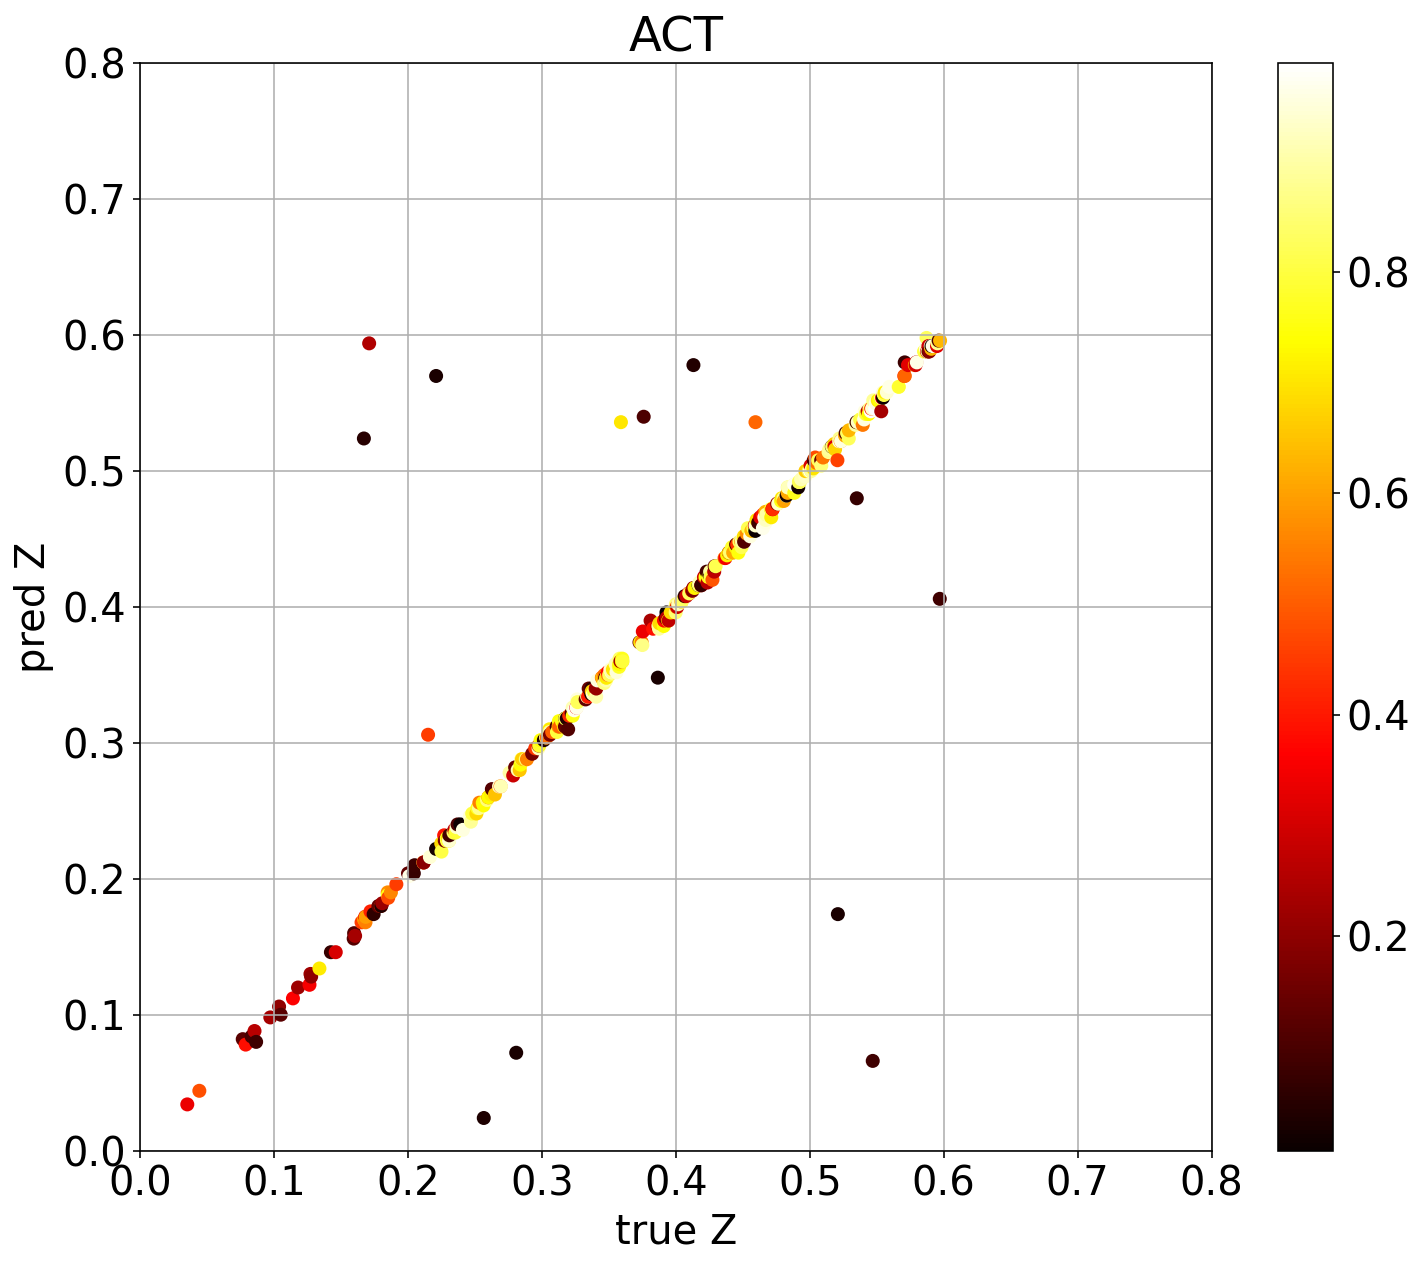

In [39]:
# Диаграмма рассеивания модели второго уровня (градиентный бустинг)

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim((0.0, 0.8))
plt.ylim((0.0, 0.8))
plt.grid()

plt.title('ACT')
plt.xlabel('true Z')
plt.ylabel('pred Z')
plt.scatter(clusters['Z'][true_mask], boosting_pred_z_ext_lvl2[true_mask], c=boosting_scores_ext_lvl2[true_mask], cmap=plt.cm.hot);
plt.colorbar()

In [40]:
# График точности и полноты

In [41]:
prec, recall, thrs = sklearn.metrics.precision_recall_curve(close_mask, boosting_scores_ext_lvl2[true_mask])

Text(0, 0.5, 'Prec')

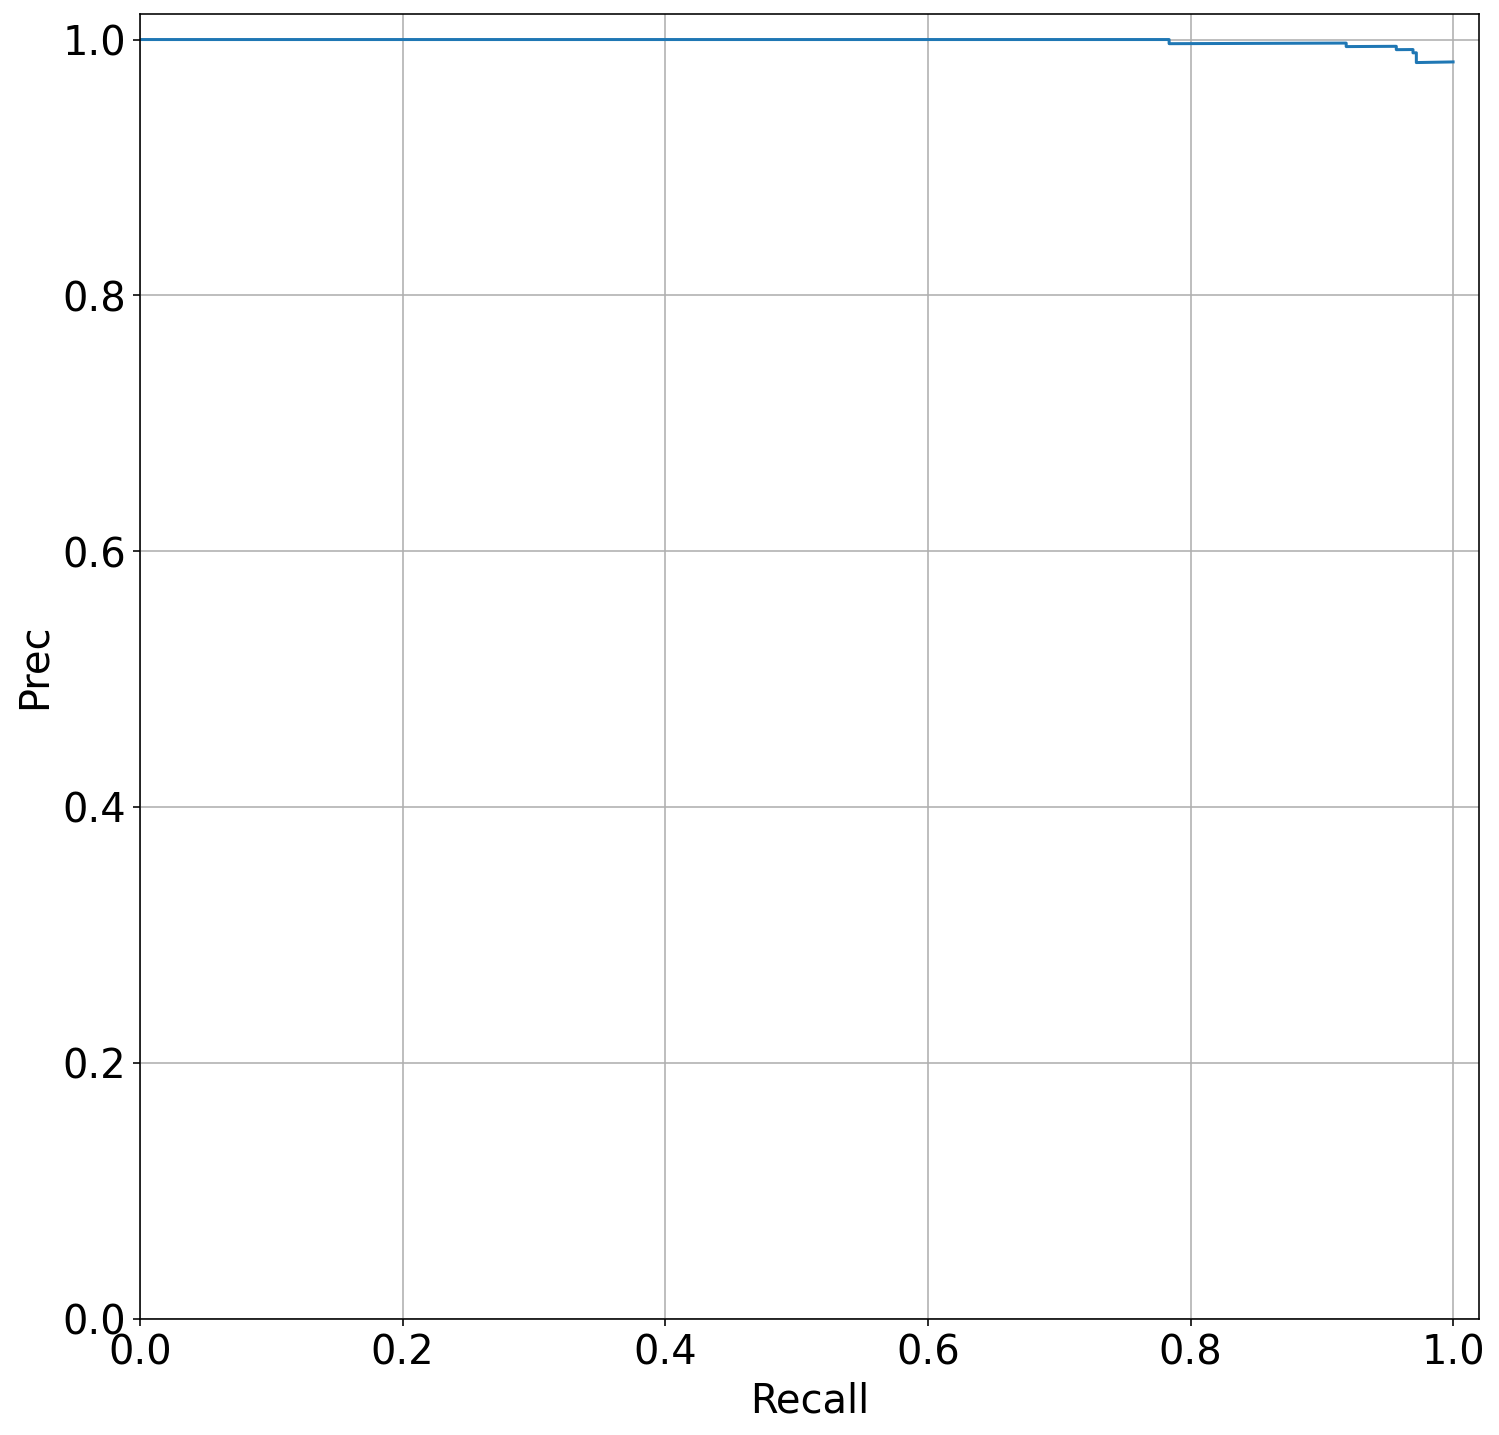

In [42]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 12))
plt.grid()
plt.xlim(0, 1.02)
plt.ylim(0, 1.02)

plt.plot(recall, prec)
plt.xlabel('Recall')
plt.ylabel('Prec')

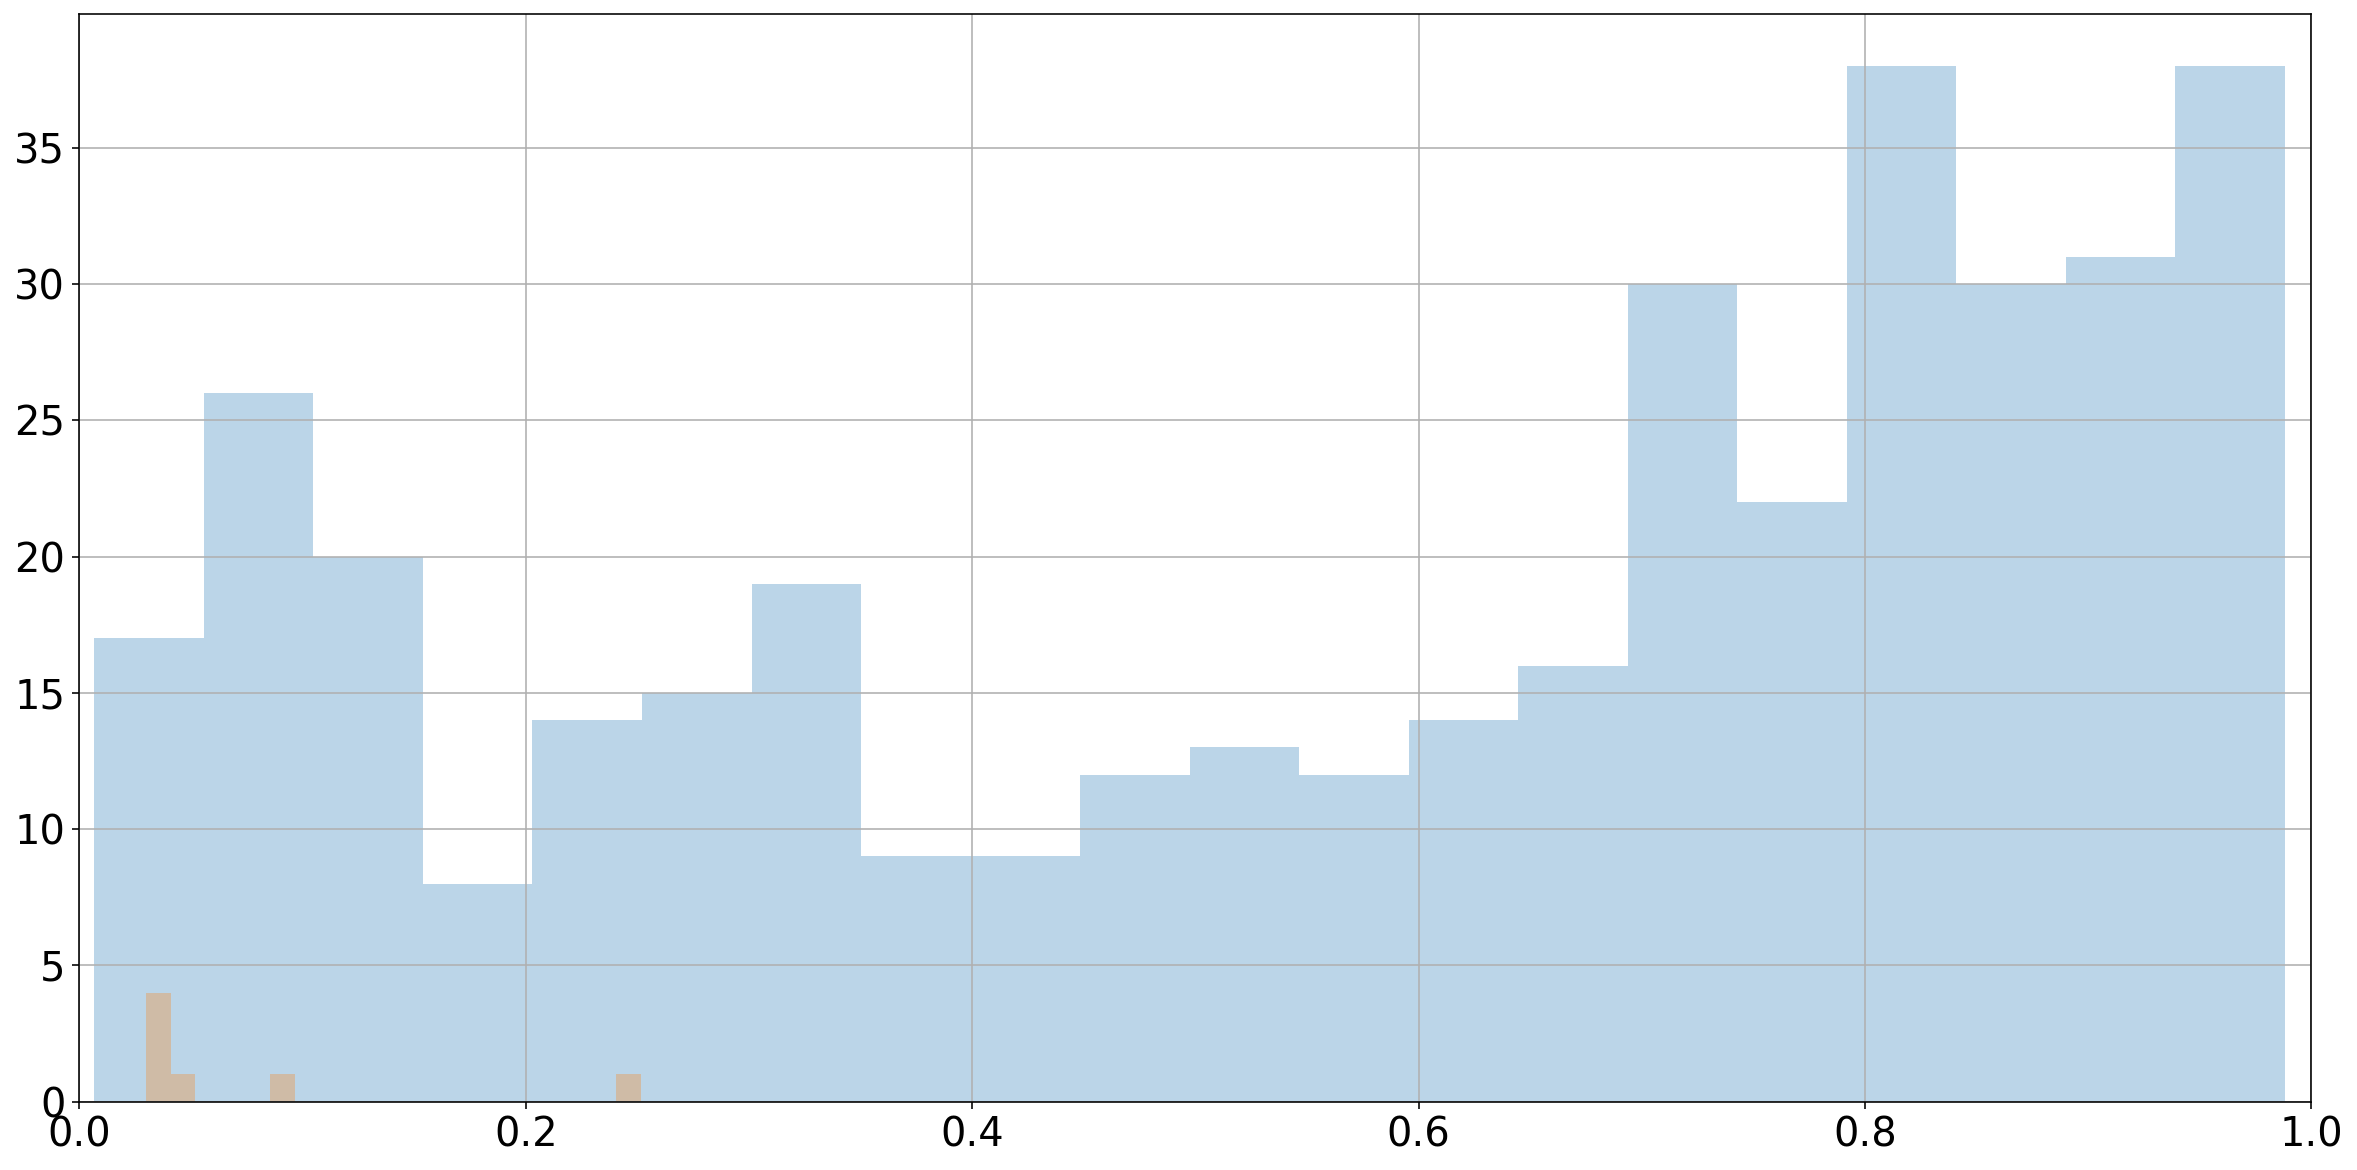

In [43]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 10))
plt.xlim((0, 1))
plt.grid()

plt.hist(boosting_scores_ext_lvl2[true_mask][close_mask], bins=20, density=False, alpha=0.3);
plt.hist(boosting_scores_ext_lvl2[true_mask][~close_mask], bins=20, density=False, alpha=0.3);

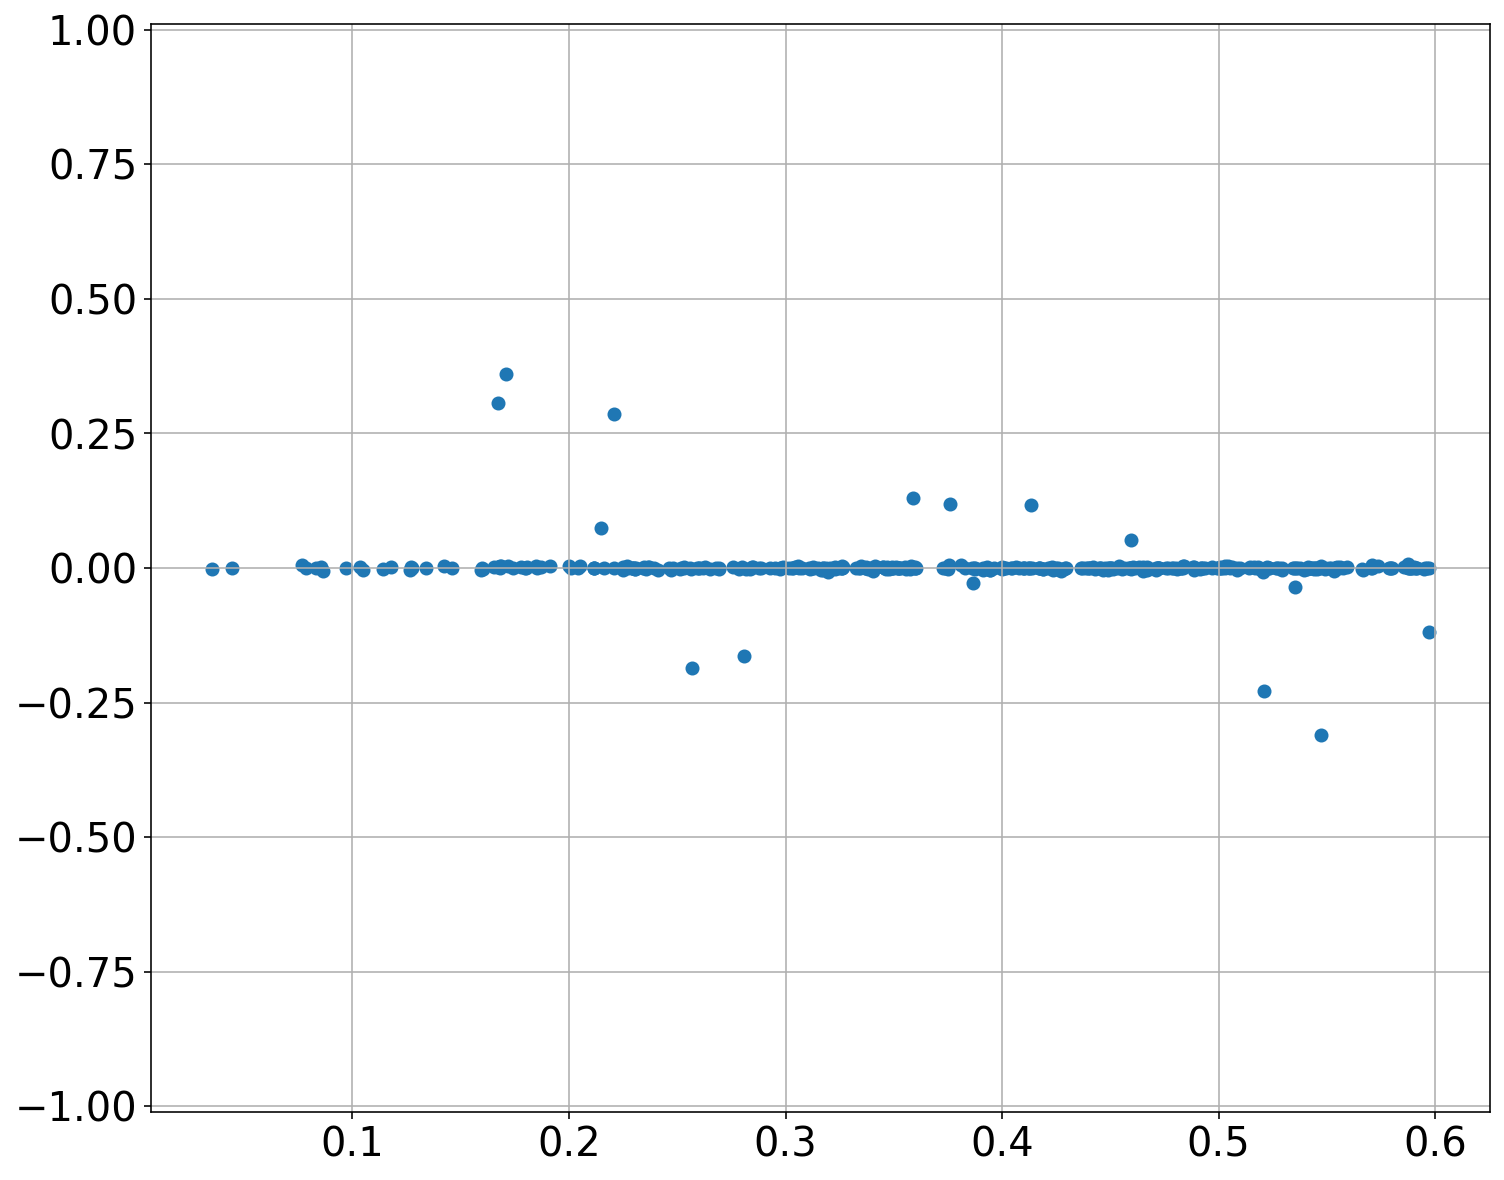

In [44]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.ylim((-1.01, 1.01))
plt.grid()

plt.scatter(clusters['Z'][true_mask], (boosting_pred_z_ext_lvl2[true_mask] - clusters['Z'][true_mask]) / (1 + clusters['Z'][true_mask]))

In [45]:
(np.abs((boosting_pred_z_ext_lvl2[false_mask] - clusters['Z'][false_mask]) / (1 + clusters['Z'][false_mask])) < 0.15).sum() / clusters['Z'][false_mask].shape[0]

0.6686088856518573

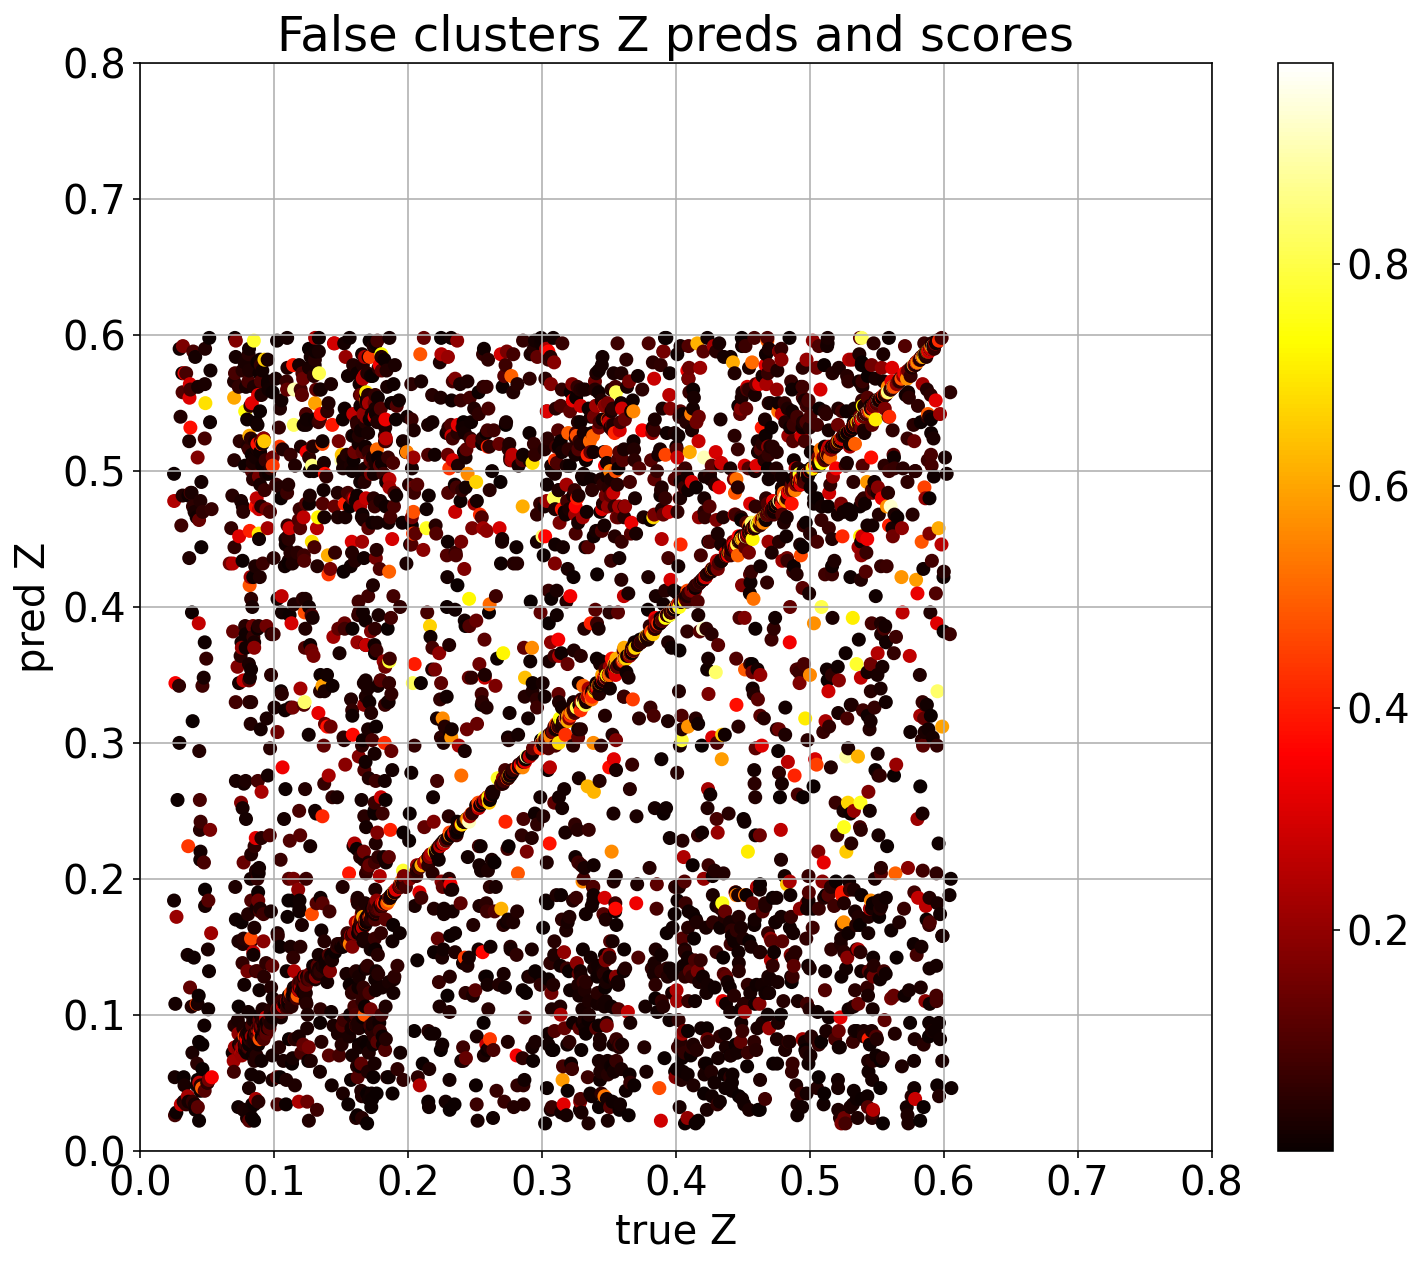

In [46]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim((0.0, 0.8))
plt.ylim((0.0, 0.8))
plt.grid()

plt.title('False clusters Z preds and scores')
plt.xlabel('true Z')
plt.ylabel('pred Z')
plt.scatter(clusters['Z'][false_mask], boosting_pred_z_ext_lvl2[false_mask], c=boosting_scores_ext_lvl2[false_mask], cmap=plt.cm.hot);
plt.colorbar()

In [47]:
for i in range(len(boostings)):
    boostings[i].booster_.save_model(f'boosting_ACT_02_{i}.txt', num_iteration=boostings[0].booster_.best_iteration)

In [48]:
# Модель на основе ближайшего соседа

In [49]:
def knn_z_model(galaxies, clusters, k):
    galaxies_coords = galaxies[['RA', 'DEC']].values
    galaxies_Z = galaxies['Z'].values
    clusters_coords = clusters[['RA', 'DEC']].values
    clusters_Z = clusters['Z'].values
    kd_tree = KDTree(galaxies_coords)
    
    dists, ids = kd_tree.query(clusters_coords, k=k, return_distance=True)
    z = galaxies_Z[ids]
    res = np.concatenate((z, dists), axis=1).reshape(-1, 2, k)
    knn_pred_z = np.median(res[:, 0, :], axis=1)
    knn_score_m = (np.abs(res[:,0,:] - knn_pred_z.reshape(-1, 1)) < 1e-7)
    knn_score = 1 / res[:,1,:][knn_score_m]
    
    return res, knn_pred_z, knn_score

res, knn_pred_z, knn_score = knn_z_model(galaxies, clusters[true_mask], 1)

In [50]:
close_mask_knn = (np.abs((knn_pred_z - clusters['Z'][true_mask]) / (1 + clusters['Z'][true_mask])) < CLOSE_THR)

In [51]:
# Доля катастрофических выбросов модели на основе ближайшего соседа

1 - close_mask_knn.sum() / clusters['Z'][true_mask].shape[0]

0.02749999999999997

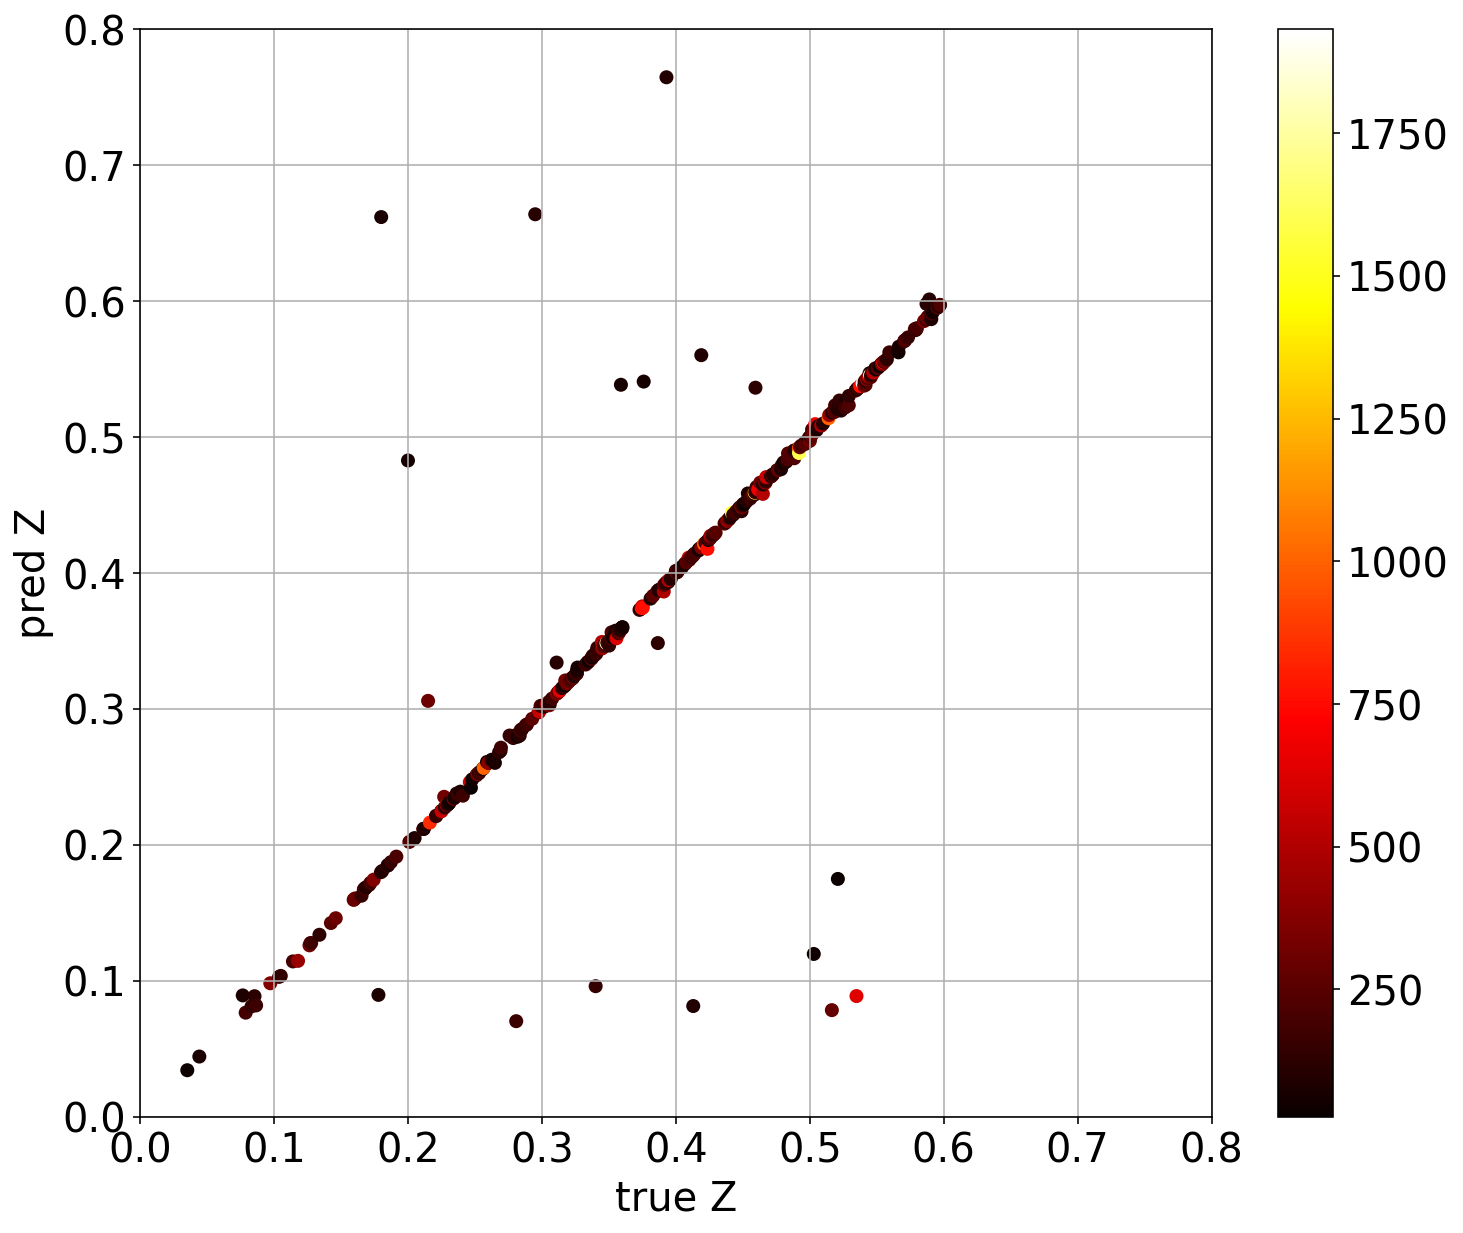

In [52]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim((0.0, 0.8))
plt.ylim((0.0, 0.8))
plt.grid()

plt.xlabel('true Z')
plt.ylabel('pred Z')
plt.scatter(clusters['Z'][true_mask], knn_pred_z, c=knn_score, cmap=plt.cm.hot);
plt.colorbar()

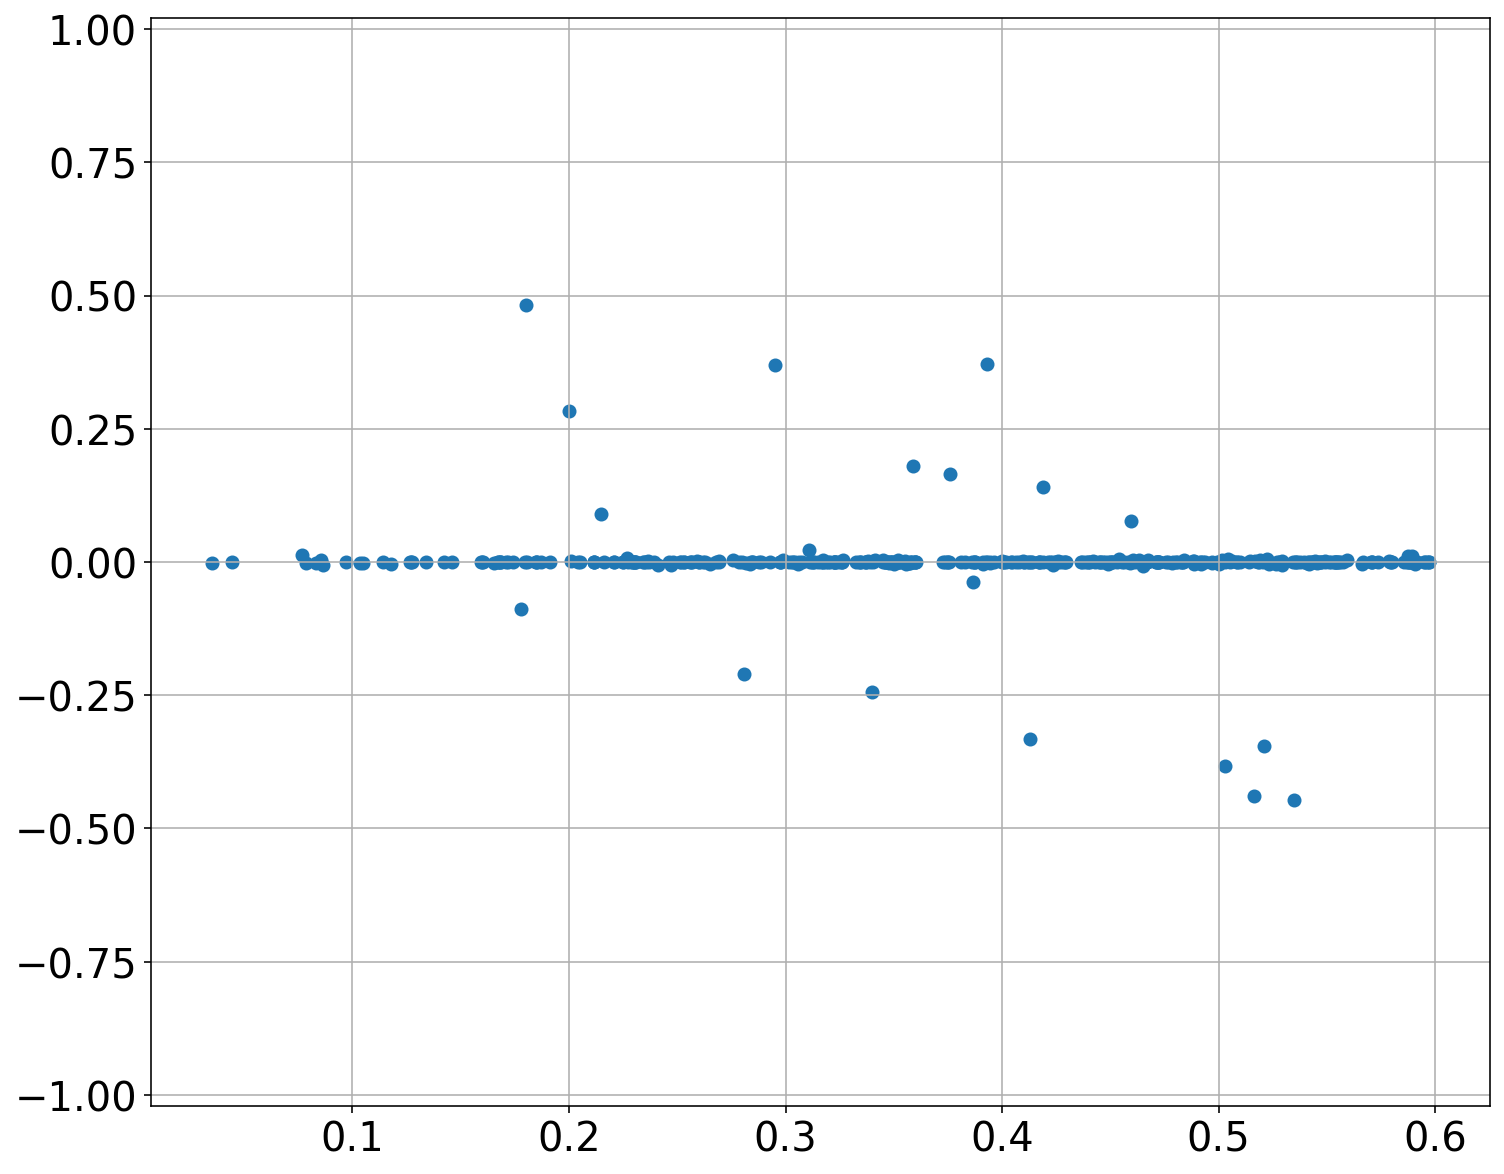

In [53]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.ylim((-1.02, 1.02))
plt.grid()

plt.scatter(clusters['Z'][true_mask], knn_pred_z - clusters['Z'][true_mask], cmap=plt.cm.hot);

In [54]:
clusters[clusters['ID'] == 22]['RA'].values[0]

205.5166593132945

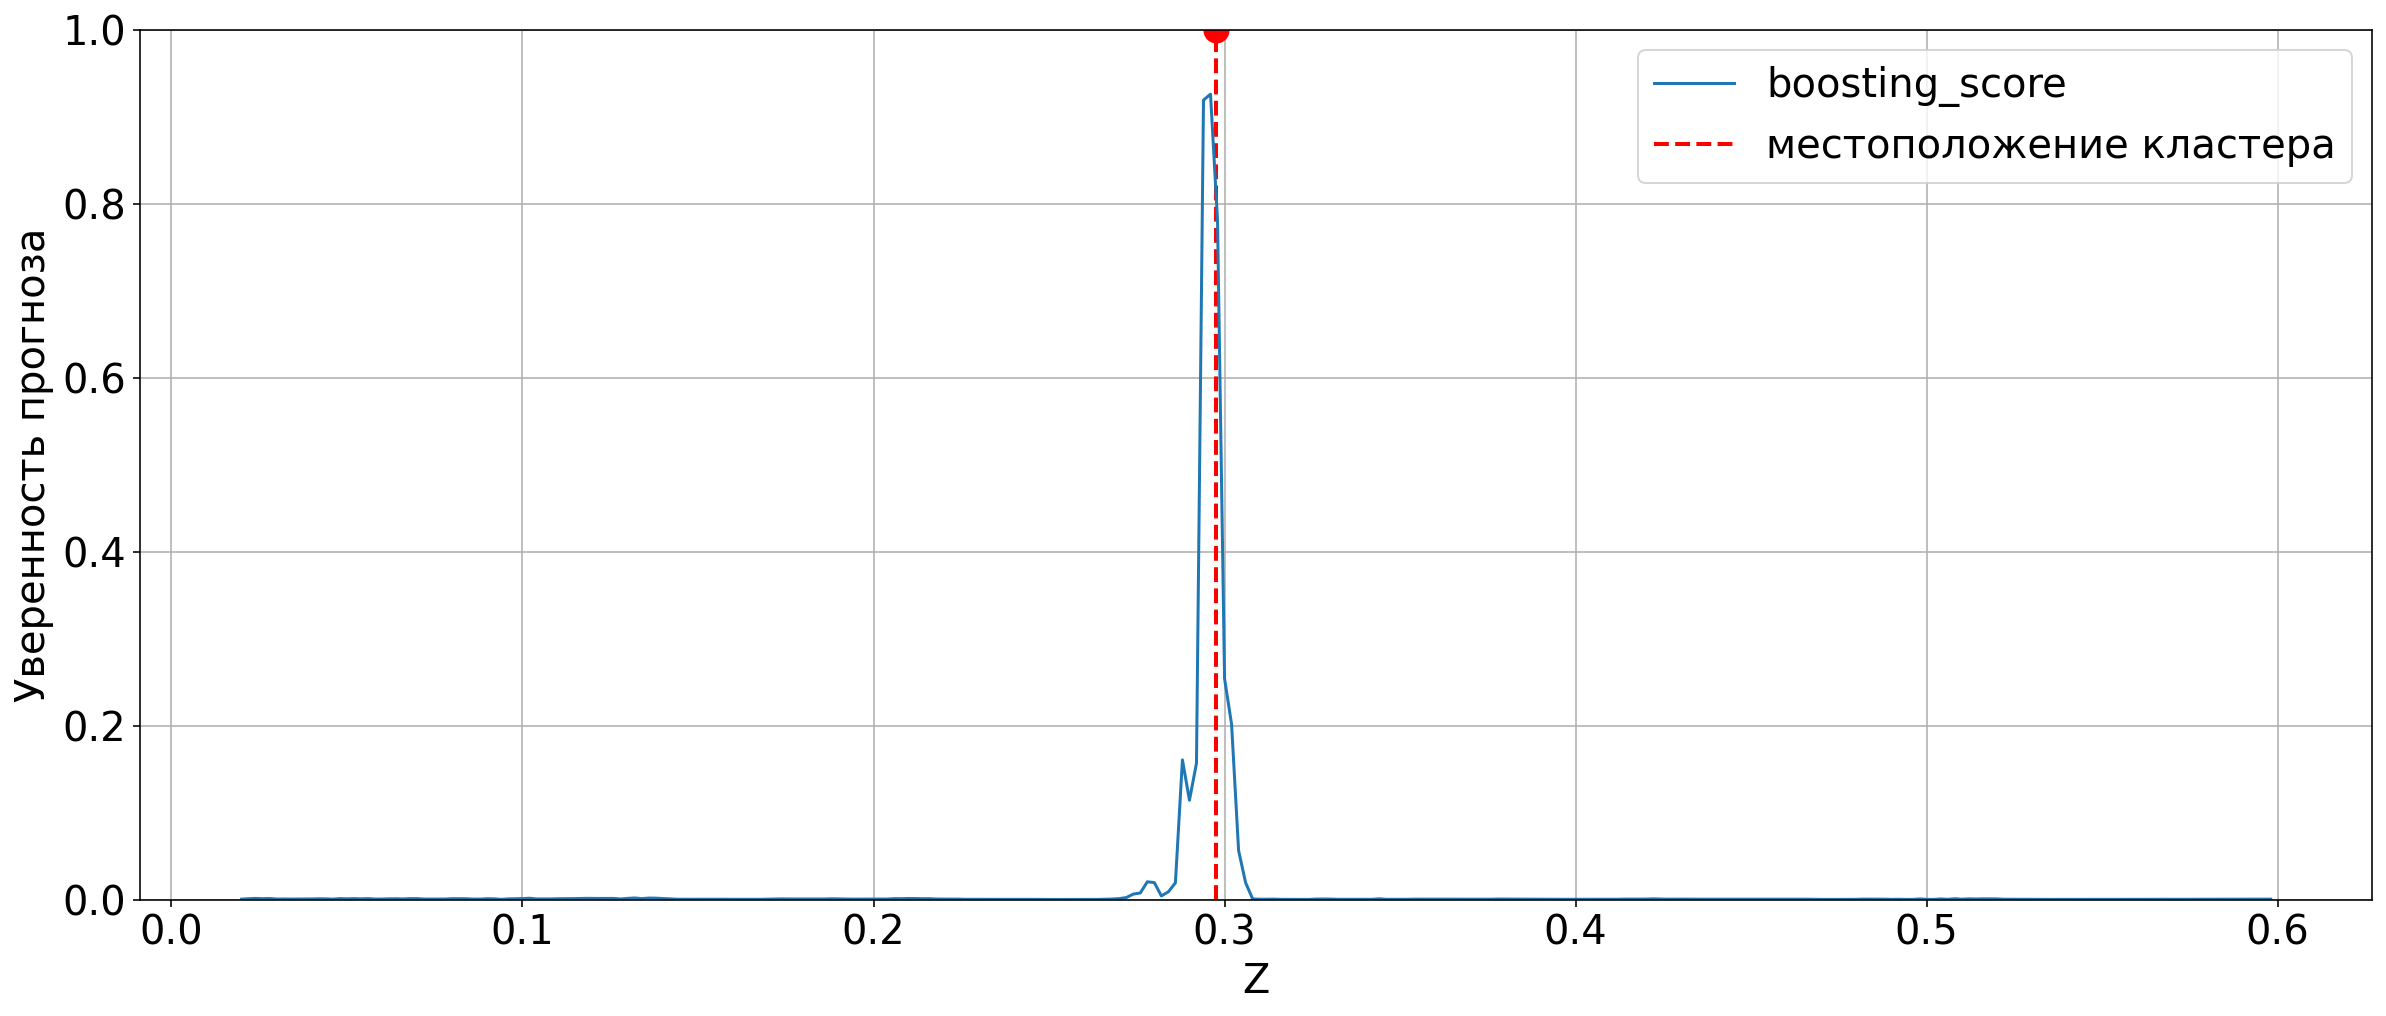

In [55]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 8))
plt.grid()
plt.ylim(0, 1)

ID = 100

plt.plot(
    clusters_ext[clusters_ext['ID'] == ID]['Z'],
    clusters_ext[clusters_ext['ID'] == ID]['boosting_score'],
    label='boosting_score'
)

plt.plot(
    clusters_ext[clusters_ext['ID'] == ID]['Z_true'].iloc[0], 
    1, 'ro', markersize=12
)
plt.vlines(
    clusters_ext[clusters_ext['ID'] == ID]['Z_true'].iloc[0],
    0, 1, colors='r', linestyles='--', linewidth=2, alpha=1.0, label='местоположение кластера'
)

plt.xlabel('Z')
plt.ylabel('Уверенность прогноза')
plt.legend()

/home/svasilyev/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


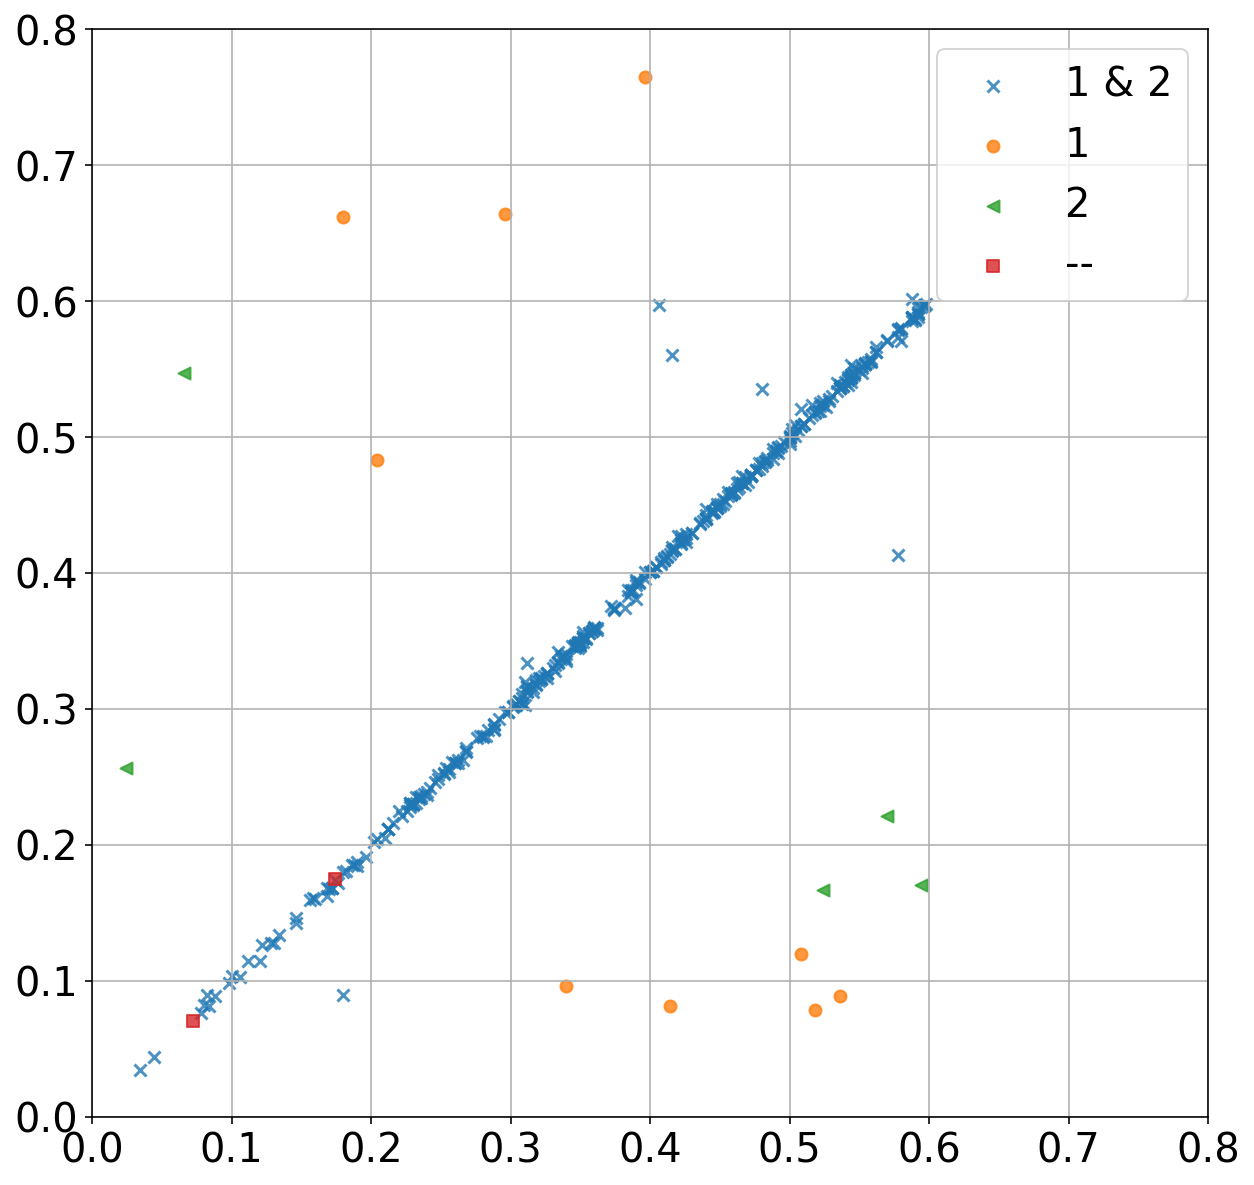

In [56]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((0.0, 0.8))
plt.ylim((0.0, 0.8))
plt.grid()

plt.scatter(
    boosting_pred_z_ext_lvl2[true_mask][close_mask * close_mask_knn], 
    knn_pred_z[close_mask * close_mask_knn], 
    alpha=0.8, label='1 & 2', marker='x'
)
plt.scatter(
    boosting_pred_z_ext_lvl2[true_mask][close_mask * ~close_mask_knn], 
    knn_pred_z[close_mask * ~close_mask_knn], 
    alpha=0.8, label='1', marker='o'
)
plt.scatter(
    boosting_pred_z_ext_lvl2[true_mask][~close_mask * close_mask_knn], 
    knn_pred_z[~close_mask * close_mask_knn], 
    alpha=0.8, label='2', marker='<'
)
plt.scatter(
    boosting_pred_z_ext_lvl2[true_mask][~close_mask * ~close_mask_knn], 
    knn_pred_z[~close_mask * ~close_mask_knn], 
    alpha=0.8, label='--', marker='s'
)

plt.legend()

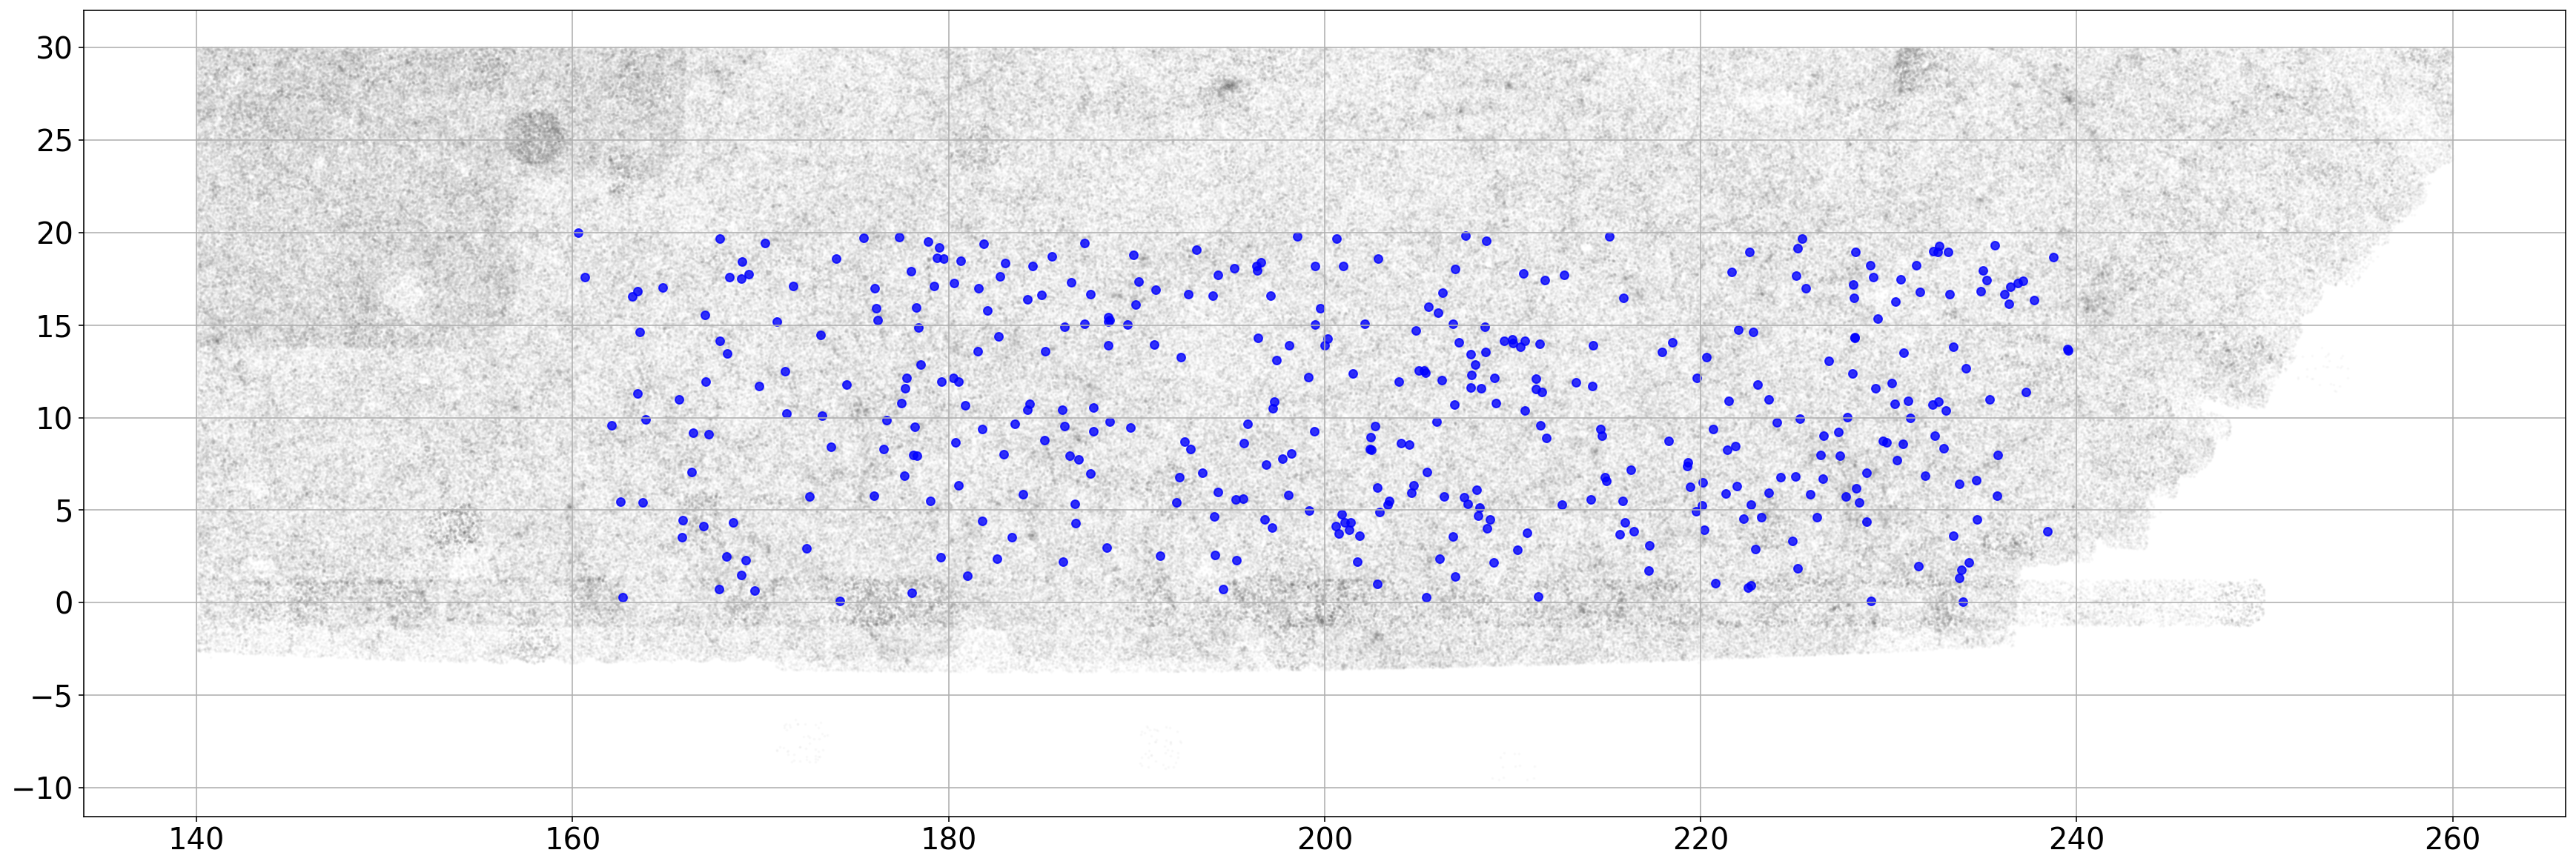

In [57]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(30, 10))
plt.grid()

plt.scatter(galaxies['RA'], galaxies['DEC'], s=1, alpha=0.03, c='gray')
plt.scatter(
    clusters[true_mask]['RA'].values, 
    clusters[true_mask]['DEC'].values, 
    s=30, alpha=0.8, c='b'
)

In [58]:
# clusters.to_csv('ACT_02_clusters.csv', index=False)
# clusters_ext.to_csv('ACT_02_clusters_ext.csv', index=False)
# np.save('ACT_02_feas.npy', feas)
# np.save('ACT_02_feas_ext.npy', feas_ext)

In [59]:
# lr = 0.05
# n_estimators_range = list(range(200, 1800, 200))
# max_depth_range = list(range(2, 18, 2))
# min_child_samples_range = list(range(10, 110, 10))

# scores = np.zeros((len(max_depth_range), len(min_child_samples_range)))
# n_estimators_scores = np.zeros((len(max_depth_range), len(min_child_samples_range)))

# for i, max_depth in tqdm(enumerate(max_depth_range)):
#     for j, min_child_samples in enumerate(min_child_samples_range):
#         max_score, max_n_estimators = -1, -1
        
#         for n_estimators in n_estimators_range:
#             boostings = []
#             boosting_scores = np.zeros(clusters.shape[0])
#             boosting_rocaucs = []
#             for train_index, test_index, weights in folds:
#                 boosting = lgbm.LGBMClassifier(
#                     boosting_type='gbdt', objective='binary',
#                     learning_rate=lr, n_estimators=n_estimators,
#                     max_depth=max_depth, min_child_samples=min_child_samples 
#                 ).fit(feas[train_index], y[train_index], weights)
#                 boostings.append(boosting)
#                 preds = boosting.predict_proba(feas[test_index])[:,1].reshape(-1)
#                 boosting_scores[test_index] = preds
#                 boosting_rocaucs.append(roc_auc_score(y[test_index], preds))

#             score = roc_auc_score(y, boosting_scores)
#             if score > max_score:
#                 max_score = score
#                 max_n_estimators = n_estimators
            
#             print(score)
#             scores[i, j] = score
#             n_estimators_scores[i, j] = n_estimators